In [1]:
import sys
!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install graphviz

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%cd /home/opencog

/home/opencog


In [3]:
from opencog.atomspace import AtomSpace, types
from opencog.scheme_wrapper import scheme_eval
from opencog.type_constructors import *
from opencog.atomspace import get_refreshed_types, get_type, get_type_name

In [4]:
atomspace = AtomSpace()

In [5]:
#deps= "/home/opencog/opencog_deps"
#sample_dataset = "/opt/sample_dataset.scm"
#deps= "opencog_deps"
#sample_dataset = "sample_dataset.scm"

#load the opencog_deps file which has the modules necessary to make the pattern matching functions run
#scheme_eval(atomspace, '(primitive-load "{}")'.format(deps))

# JJJ
scheme_eval(atomspace, "(use-modules (ice-9 readline))")
scheme_eval(atomspace, "(activate-readline)")
scheme_eval(atomspace, "(debug-enable 'backtrace)")
scheme_eval(atomspace, "(read-enable 'positions)")
scheme_eval(atomspace, "(use-modules (opencog))")
scheme_eval(atomspace, "(use-modules (opencog exec))")
scheme_eval(atomspace, "(use-modules (opencog bioscience))")
scheme_eval(atomspace, "(use-modules (rnrs base))")
scheme_eval(atomspace, "(use-modules (rnrs exceptions))")
scheme_eval(atomspace, "(use-modules (ice-9 textual-ports))")
scheme_eval(atomspace, "(use-modules (ice-9 regex))")
scheme_eval(atomspace, "(use-modules (srfi srfi-98))")
scheme_eval(atomspace, "(use-modules (ice-9 match))")
scheme_eval(atomspace, "(use-modules (ice-9 threads))")
scheme_eval(atomspace, "(use-modules (ice-9 ftw))")
scheme_eval(atomspace, "(use-modules (srfi srfi-1))")

b'\n'

In [6]:
scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/biogrid_gene_gene_3.5.177.scm"))
#scheme_eval(atomspace, '(primitive-load "{}")'.format("smallgene/string_ggi.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/GO.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/Go-Plus.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/GO_annotation.scm"))
#scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/NCBI2Reactome_PE_Pathway.txt2.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/NCBI2Reactome_PE_Pathway.txt.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/reactome.scm"))
scheme_eval(atomspace, '(primitive-load "{}")'.format("kbs/smpdb_gene.scm"))

#verify the atoms are loaded
print("after datasets: " + scheme_eval(atomspace, "(count-all)").decode("utf-8"))

after datasets: 2222880



In [7]:
#specify the default atomspace to use for running queries
set_default_atomspace(atomspace)

In [8]:
#we need to refresh the type dict so that it contains the newly added types [GeneNode, MoleculeNode]
types = get_refreshed_types()

In [9]:
import copy
def find_deepwalk_node_type(node): 
    deepwalk_node_type = None
    node_defs = { 
            #take the first that begins with the string"
            "ConceptNode":[("R-HSA","rhsapathway"), ("SMP","smppathway"), ("GO:","geneontologyterm")],
            "PredicateNode":[("has_location","location")],
            "GeneNode":[("","gene")]
    }
    #print("node.type_name")
    #print(node.type_name)
    if (node.type_name in node_defs):
        prefix_list = copy.deepcopy(node_defs[node.type_name])
        found = False
        while not found and len(prefix_list)> 0:
            prefix_tuple = prefix_list.pop(0)
            #print ("prefix_tuple")
            #print (prefix_tuple)
            if prefix_tuple[0] == "" or node.name.startswith(prefix_tuple[0]):
                found == True
                deepwalk_node_type = prefix_tuple[1]
                
    return deepwalk_node_type

In [10]:
from opencog.bindlink import execute_atom

def construct_eval_set_query(predicate, node, other_type=None):
    '''
    Note: this function is returning the Evalutaion Links instead of the grounded node because 
    the links have the truth values
    '''
    if other_type is None:      
        bind_atom = \
            GetLink(
                VariableNode("$g"),
                EvaluationLink(
                    PredicateNode(predicate),
                    SetLink(
                        node,
                        VariableNode("$g")
                    )
                ), 
                EvaluationLink(
                    PredicateNode(predicate),
                    SetLink(
                        node,
                        VariableNode("$g")
                    )
                )
            )
    else:
        bind_atom = \
            BindLink(
                TypedVariableLink(VariableNode("$g"), TypeNode(other_type)),
                EvaluationLink(
                    PredicateNode(predicate),
                    SetLink(
                        node,
                        VariableNode("$g")
                    )
                ), 
                EvaluationLink(
                    PredicateNode(predicate),
                    SetLink(
                        node,
                        VariableNode("$g")
                    )
                )
            )
        
    result = execute_atom(atomspace, bind_atom)
    #print(result)
    return result.out

In [11]:
from opencog.bindlink import execute_atom

def construct_eval_query(predicate, node, other_type=None):
    if other_type is None:      
        bind_atom = \
            BindLink(
                VariableNode("$g"),
                EvaluationLink(
                    PredicateNode(predicate),
                    ListLink(
                        node,
                        VariableNode("$g")
                    )
                ), 
                VariableNode("$g")
            )
    else:
        bind_atom = \
            BindLink(
                TypedVariableLink(VariableNode("$g"), TypeNode(other_type)),
                EvaluationLink(
                    PredicateNode(predicate),
                    ListLink(
                        node,
                        VariableNode("$g")
                    )
                ), 
                VariableNode("$g")
            )
        
    result = execute_atom(atomspace, bind_atom)
    return result.out

In [12]:
from opencog.bindlink import execute_atom
def construct_member_query(node):
    member_atom = \
        BindLink(VariableNode("$g"),
                 MemberLink(
                    node,
                    VariableNode("$g")
                 ),
                 VariableNode("$g")
        )
    
    result = execute_atom(atomspace, member_atom)
    return result.out

In [13]:
from opencog.bindlink import execute_atom
def construct_inheritance_query(node):
    member_atom = \
        BindLink(VariableNode("$g"),
                 InheritanceLink(
                    node,
                    VariableNode("$g")
                 ),
                 VariableNode("$g")
        )
    result = execute_atom(atomspace, member_atom)
    return result.out

In [14]:
from opencog.bindlink import execute_atom
def construct_subset_query(node):
    member_atom = \
        BindLink(VariableNode("$g"),
                 SubsetLink(
                    node,
                    VariableNode("$g")
                 ),
                 VariableNode("$g")
                )
    result = execute_atom(atomspace, member_atom)
    return result.out

In [15]:
def construct_context_query(gene):
    query_atom = \
        BindLink(
            VariableList(
                TypedVariableLink(VariableNode("$p"), TypeNode("ConceptNode")),
                TypedVariableLink(VariableNode("$q"), TypeNode("ConceptNode"))
            ),
            ContextLink(
                MemberLink(
                    gene,
                    VariableNode ("$p")
                ),
                EvaluationLink(
                     PredicateNode ("has_location"),
                     ListLink(
                        gene,
                        VariableNode ("$q")
                     )
                )
            ),
            ListLink(
                VariableNode("$p"),
                VariableNode("$q")
            )
        )
    result = execute_atom(atomspace, query_atom)
    return result.out

In [16]:
linkset = {"inhibits", "is-inhibited-by", "ptmod", "is-ptmoded-by", "expresses","is-expressed-by", 
           "activates", "is-activated-by", "catalyzes", "is-catalyzed-by", "binds-with", "reacts-with", 
           "in-smp-pathway", "has-smp-pathway-member", "in-gene-ontology",
           "has-gene-ontology-member", 'is-in', 'in-context-of', 'is-context-where', 
           'has', "inherits-pathway", "pathway-inherited-by", 
           "inherits-geneontologyterm", "geneontologyterm-inherited-by", "positively-regulates",
           "is-positively-regulated-by", "negatively-regulates", "is-negatively-regulated-by",
           'has-variant','is-variant-of',"has-person-member", "is-person-member-of", 
           "superc-has-variant", "is-variant-of-superc",
           "normal-has-variant", "is-variant-of-normal"
          }
geneset = set()
rhsapathwayset = set()
smppathwayset = set()
geneontologytermset = set()
locationset = set()

for node in atomspace.get_atoms_by_type(types.Node):
    deepwalk_type = find_deepwalk_node_type(node)

    if deepwalk_type and deepwalk_type == "gene":
        geneset.add(node.name)
    if deepwalk_type and deepwalk_type == "rhsapathway":
        rhsapathwayset.add(node.name)
    if deepwalk_type and deepwalk_type == "smppathway":
        smppathwayset.add(node.name)
    if deepwalk_type and deepwalk_type == "geneontologyterm":
        geneontologytermset.add(node.name)
    if deepwalk_type and deepwalk_type == "location":
        locationset.add(node.name)

genelist = list(geneset)
print(len(genelist))
geneontologytermlist = list(geneontologytermset)
print(len(geneontologytermlist))

24168
44835


In [17]:
import pandas as pd

biomapdf = pd.read_csv("csv/mosesDoseNoFeature2Gene.csv")
centdf = pd.read_csv("csv/scV1kg26noDose.csv")
print(len(biomapdf))

genes = set(biomapdf['Name'])
print(len(genes))

intersection = genes.intersection(geneset)
print(len(intersection))

current_map = biomapdf[biomapdf['Name'].isin(intersection)]
print(len(current_map))

51877
1843
992
40295


In [18]:
phrases = set()
truth_values = {}
halfphrases = set()
proteinset = set()
for index, row in current_map.iterrows():
    phrases.add((row['Name'].strip(),'has-variant',row['feature'].strip()))
    halfphrases.add((row['Name'].strip(),'has-variant',row['feature'].strip()))
    phrases.add((row['feature'].strip(),'is-variant-of',row['Name'].strip()))
    proteinset.add(row['feature'].strip())

In [19]:
supercpersonset = set()
normalpersonset = set()
persontypeset = set()
persontypeset.add('normal')
persontypeset.add('superc')
isa_supercenturian = []
for (columnName, columnData) in centdf.iteritems():
    if columnName == 'case':
        isa_supercenturian = columnData.values
    else:
        for index,has_expressed in enumerate(columnData.values):
            name = ""
            if isa_supercenturian[index] == 1:
                name = "superc"+str(index)
                phrases.add(("superc","has-person-member",name))
                halfphrases.add(("superc","has-person-member",name))
                phrases.add((name, "is-person-member-of", "superc"))
                supercpersonset.add(name)
                if has_expressed == 1:
                    phrases.add((name,"superc-has-variant",columnName.strip()))
                    halfphrases.add((name,"superc-has-variant",columnName.strip()))
                    phrases.add((columnName.strip(), "is-variant-of-superc", name))
            else:
                name = "normal"+str(index)
                phrases.add(("normal","has-person-member",name))
                halfphrases.add(("normal","has-person-member",name))
                phrases.add((name, "is-person-member-of", "normal"))
                normalpersonset.add(name)
                if has_expressed == 1:
                    phrases.add((name,"normal-has-variant",columnName.strip()))
                    halfphrases.add((name,"normal-has-variant",columnName.strip()))
                    phrases.add((columnName.strip(), "is-variant-of-normal", name))
supercpersonlist = list(supercpersonset)

In [20]:
def add_gene_triplet(node,name,verb,reverse):
    result3 = construct_eval_set_query(name, node, other_type='GeneNode')
    if result3:
        for evalLink in result3:
            tv = None
            if hasattr(evalLink,"tv"):
                strength = evalLink.tv.mean
                confidence = evalLink.tv.confidence
                tv = (strength,confidence)
                #print(tv)
            # JJJ .out[0] or .out[1] ??
            node2 = evalLink.out[1].out[0]
            deepwalk_type2 = find_deepwalk_node_type(node2)
            #print(deepwalk_type2)
            if deepwalk_type2 == "gene":
                tup = (node.name.strip(), verb, node2.name.strip())
                reverse_tup = (node2.name.strip(), reverse, node.name.strip())
                if (node2.name.strip(),node.name.strip()) not in existingTuples:
                    halfphrases.add(tup)
                    existingTuples.add((node.name.strip(),node2.name.strip()))
                phrases.add(tup)
                phrases.add(reverse_tup)
                if tv is not None:
                    truth_values[tup]=tv
                    truth_values[reverse_tup]=tv

In [21]:
existingTuples = set()

for node in atomspace.get_atoms_by_type(types.Node):
    #print('node.name')
    #print(node.name)
    deepwalk_type = find_deepwalk_node_type(node)
    if deepwalk_type and deepwalk_type == "gene":
        result = construct_member_query(node)
        if result:
            for node2 in result:
                deepwalk_type2 = find_deepwalk_node_type(node2)
                if deepwalk_type2 == "smppathway":
                    halfphrases.add((node.name.strip(), "in-smp-pathway", node2.name.strip()))
                    phrases.add((node.name.strip(), "in-smp-pathway", node2.name.strip()))
                    phrases.add((node2.name.strip(), "has-smp-pathway-member", node.name.strip()))
                elif deepwalk_type2 == "geneontologyterm":
                    halfphrases.add((node.name.strip(), "in-gene-ontology", node2.name.strip()))
                    phrases.add((node.name.strip(), "in-gene-ontology", node2.name.strip()))
                    phrases.add((node2.name.strip(), "has-gene-ontology-member", node.name.strip()))
        result2 = construct_context_query(node)
        if result2:
            for node2 in result2:
                halfphrases.add((node.name.strip(), 'is-in', node2.out[1].name.strip(), 'in-context-of', node2.out[0].name.strip()))
                phrases.add((node.name.strip(), 'is-in', node2.out[1].name.strip(), 'in-context-of', node2.out[0].name.strip()))
                phrases.add((node2.out[0].name.strip(), 'is-context-where', node2.out[1].name.strip(), 'has', node.name.strip()))
       
        #result3 = construct_eval_query('interacts_with', node, other_type='GeneNode')
        add_gene_triplet(node,'inhibition','inhibits','is-inhibited-by')
        add_gene_triplet(node,'ptmod','ptmod','is-ptmoded-by')
        add_gene_triplet(node,'expression','expresses','is-expressed-by')
        add_gene_triplet(node,'activation','activates','is-activated-by')
        add_gene_triplet(node,'catalysis','catalyzes','is-catalyzed-by')
        add_gene_triplet(node,'binding','binds-with','binds-with')
        add_gene_triplet(node,'reaction','reacts-with','reacts-with')
    
    elif deepwalk_type and deepwalk_type == "rhsapathway":
        result10 = construct_inheritance_query(node)
        if result10:
            for node2 in result10:
                deepwalk_type2 = find_deepwalk_node_type(node2)
                if deepwalk_type2 == "rhsapathway":
                    halfphrases.add((node.name.strip() ,"inherits-pathway", node2.name.strip() ))
                    phrases.add((node.name.strip() ,"inherits-pathway", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"pathway-inherited-by", node.name.strip() ))
    elif deepwalk_type and deepwalk_type == "geneontologyterm":
        result11 = construct_inheritance_query(node)
        if result11:
            for node2 in result11:
                deepwalk_type2 = find_deepwalk_node_type(node2)
                if deepwalk_type2 == "geneontologyterm":
                    halfphrases.add((node.name.strip() ,"inherits-geneontologyterm", node2.name.strip() ))
                    phrases.add((node.name.strip() ,"inherits-geneontologyterm", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"geneontologyterm-inherited-by", node.name.strip() ))
        result12 = construct_eval_query('GO_positively_regulates', node, other_type='ConceptNode')
        if result12:
            for node2 in result12:
                deepwalk_type2 = find_deepwalk_node_type(node2)
                if deepwalk_type2 == "geneontologyterm":
                    halfphrases.add((node.name.strip() ,"positively-regulates", node2.name.strip() ))
                    phrases.add((node.name.strip() ,"positively-regulates", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"is-positively-regulated-by", node.name.strip() ))
        result13 = construct_eval_query('GO_negatively_regulates', node, other_type='ConceptNode')
        if result13:
            for node2 in result13:
                deepwalk_type2 = find_deepwalk_node_type(node2)
                if deepwalk_type2 == "geneontologyterm":
                    halfphrases.add((node.name.strip() ,"negatively-regulates", node2.name.strip() ))
                    phrases.add((node.name.strip() ,"negatively-regulates", node2.name.strip() ))
                    phrases.add((node2.name.strip() ,"is-negatively-regulated-by", node.name.strip() ))

In [22]:
includedNodesSet = set()
includedRelationsSet = set()
includedTripletsSet = set()
for tup in halfphrases:
    if len(tup) > 1:
        includedNodesSet.add(tup[0])
        includedRelationsSet.add(tup[1])
        includedNodesSet.add(tup[2])
    if len(tup) > 3:
        includedRelationsSet.add(tup[3])
        includedNodesSet.add(tup[4])
    if len(tup) == 3:
        includedTripletsSet.add(tup)
    elif len(tup) == 5:
        splittup = tuple([tup[0],tup[1],tup[2]])
        includedTripletsSet.add(splittup)
        splittup = tuple([tup[2],tup[3],tup[4]])
        includedTripletsSet.add(splittup)

In [23]:
percent_test = 10
percent_valid = 10
num_test = int(len(phrases) * 0.01 * percent_test)
num_valid_and_test = int(len(phrases) * 0.01 * percent_valid) + num_test

file = open("entities.dict","w") 
for i,node in enumerate(includedNodesSet):
    file.write("{0}\t{1}\n".format(i,node)) 
file.close() 
 
file = open("relations.dict","w") 
for i,rel in enumerate(includedRelationsSet):
    file.write("{0}\t{1}\n".format(i,rel)) 
file.close() 

file1 = open("test.txt","w") 
file2 = open("valid.txt","w") 
file3 = open("train.txt","w") 
for i,t in enumerate(includedTripletsSet):
    if i < num_test:
        file1.write("{0}\t{1}\t{2}\n".format(t[0],t[1],t[2])) 
    elif i < num_valid_and_test:
        file2.write("{0}\t{1}\t{2}\n".format(t[0],t[1],t[2])) 
    else:
        file3.write("{0}\t{1}\t{2}\n".format(t[0],t[1],t[2])) 
    
file1.close()
file2.close()    
file3.close() 

In [24]:
len(phrases)

4945968

In [25]:
phrases

{('20:60714525_G/A', 'is-variant-of-normal', 'normal36'),
 ('SMP0060658', 'has-smp-pathway-member', 'GPD1'),
 ('9:37782111_C/T', 'is-variant-of-normal', 'normal378'),
 ('normal335', 'normal-has-variant', '19:37064267_C/T'),
 ('normal271', 'normal-has-variant', '7:22984824_T/C'),
 ('normal383', 'normal-has-variant', '17:7132556_C/T'),
 ('7:64437820_G/C', 'is-variant-of-normal', 'normal233'),
 ('normal103', 'normal-has-variant', '7:897492_A/G'),
 ('GO:0090091', 'has-gene-ontology-member', 'MELTF'),
 ('14:23058084_A/G', 'is-variant-of-normal', 'normal499'),
 ('17:47007963_C/T', 'is-variant-of-normal', 'normal314'),
 ('GO:0005654', 'has-gene-ontology-member', 'COPS7A'),
 ('normal174', 'normal-has-variant', '11:9044261_G/T'),
 ('1:1676091_C/T', 'is-variant-of-normal', 'normal319'),
 ('1:241757182_C/T', 'is-variant-of-normal', 'normal153'),
 ('FZD8', 'is-in', 'plasma membrane', 'in-context-of', 'R-HSA-4641263'),
 ('GO:2000009', 'has-gene-ontology-member', 'SNX33'),
 ('normal253', 'normal-has

In [26]:
phraselist = list(phrases)

In [27]:
#for p in phraselist:
    #print(p)

In [28]:
import pickle
try:
    with open("dict51.p", "rb") as f:
            normalized = pickle.load(f)
except Exception:
    dict1 = {}
    for tup in phrases:
        tv = truth_values[tup] if tup in truth_values else None
        if len(tup)>1:
            tup0 = tuple([tup[0]])
            if tup0 not in dict1:
                dict1[tup0]= set()
            dict1[tup0].add((("",tup[1]),1))
        if len(tup)>2:
            if (tup[0],tup[1]) not in dict1:
                dict1[(tup[0],tup[1])]= set()
            confidence = tv[1] if tv is not None else 1
            strength = "weakly" if tv is not None and tv[0]<0.25 else "moderately" if tv is not None and tv[0]<0.5 else ""
            dict1[(tup[0],tup[1])].add(((strength,tup[2]),confidence))
        if len(tup)>3:
            if (tup[0],tup[1],tup[2]) not in dict1:
                dict1[(tup[0],tup[1],tup[2])]= set()
            dict1[(tup[0],tup[1],tup[2])].add((("",tup[3]),1))
        if len(tup)>4:
            if (tup[0],tup[1],tup[2],tup[3]) not in dict1:
                dict1[(tup[0],tup[1],tup[2],tup[3]) ]= set()
            dict1[(tup[0],tup[1],tup[2],tup[3])].add((("",tup[4]),1))
    #print(dict1)
    normalized = {}
    for key, aset in dict1.items():
        numerator = sum([tup[1] for tup in aset])
        next_word_list = [(tup[0],int(tup[1])/numerator) for tup in aset]
        normalized[key] = next_word_list
    with open("dict51.p", "wb") as f:
        pickle.dump(normalized, f)

In [29]:
def roulette_wheel(tup_list):
    #given the present items in the phrase, give the next
    #works for 2 word phrases
    rand = random.random()
    summ = 0
    count = 0
    chosen_tup = None
    #print(len(tup_list))
    while count < len(tup_list) and summ < rand:
        summ += tup_list[count][1]
        #print (summ)
        count += 1
    else: 
        chosen_tup = tup_list[count-1][0]
    #print(chosen_tup)
    return chosen_tup

In [30]:
import random
def make_sentences(first_word_list):
    try:
        with open("sentences51.p", "rb") as f:
                sentences = pickle.load(f)
    except Exception:
        num_sentences = 10000000
        phrases_per_sentence = 10
        sentences = []
        for i in range(num_sentences):
            sentence = []
            for j in range(phrases_per_sentence):
                phrase = []
                finished = False
                while not finished:
                    if len(sentence) == 0:
                        word = random.choice(first_word_list)
                        phrase.append(word)
                        sentence.append(word)
                    elif len(phrase) == 0:
                        tup0 = tuple([sentence[-1]]) 
                        phrase.append(sentence[-1])
                        if tup0 in normalized:
                            w1,w2 = roulette_wheel(normalized[tup0])
                            if not w1 == "":
                                phrase.append(w1)
                                sentence.append(w1)
                            phrase.append(w2)
                            sentence.append(w2)
                    elif tuple(phrase) in normalized:
                        w1,w2 = roulette_wheel(normalized[tuple(phrase)])
                        if not w1 == "":
                            phrase.append(w1)
                            sentence.append(w1)
                        phrase.append(w2)
                        sentence.append(w2)
                    else:
                        finished = True
            sentences.append(sentence)
            if i % 10000 == 0:
                print(len(sentences))
        with open("sentences51.p", "wb") as f:
                pickle.dump(sentences, f)
    return (sentences)

In [31]:
#sentences = make_sentences(supercpersonlist)
sentences = make_sentences(geneontologytermlist)

In [32]:
for i in range(100):
        print (sentences[i])

['GO:0018471', 'inherits-geneontologyterm', 'GO:0016709', 'inherits-geneontologyterm', 'GO:0004497', 'is-positively-regulated-by', 'GO:0032770', 'has-gene-ontology-member', 'POR', 'is-in', 'endoplasmic reticulum membrane', 'in-context-of', 'R-HSA-211897', 'pathway-inherited-by', 'R-HSA-211916', 'inherits-pathway', 'R-HSA-211897', 'pathway-inherited-by', 'R-HSA-211916', 'inherits-pathway', 'R-HSA-211897', 'pathway-inherited-by', 'R-HSA-211935']
['GO:0102291', 'inherits-geneontologyterm', 'GO:0016709', 'geneontologyterm-inherited-by', 'GO:0047090', 'inherits-geneontologyterm', 'GO:0016709', 'inherits-geneontologyterm', 'GO:0004497', 'is-negatively-regulated-by', 'GO:0032769', 'geneontologyterm-inherited-by', 'GO:0032772', 'negatively-regulates', 'GO:0004503', 'is-positively-regulated-by', 'GO:0032773', 'has-gene-ontology-member', 'CDH3', 'in-gene-ontology', 'GO:0044331']
['GO:1900072', 'geneontologyterm-inherited-by', 'GO:0061426', 'inherits-geneontologyterm', 'GO:0045944', 'has-gene-ont

In [33]:
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os.path

plt.rcParams['figure.figsize'] = [100, 50]
# train model

if os.path.exists('model51.bin'):
    model = Word2Vec.load('model51.bin')
else:
    model = Word2Vec(sentences, min_count=1)
    model.save('model51.bin')
        
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)

unable to import 'smart_open.gcs', disabling that module


Word2Vec(vocab=110010, size=100, alpha=0.025)
['GO:0018471', 'inherits-geneontologyterm', 'GO:0016709', 'GO:0004497', 'is-positively-regulated-by', 'GO:0032770', 'has-gene-ontology-member', 'POR', 'is-in', 'endoplasmic reticulum membrane', 'in-context-of', 'R-HSA-211897', 'pathway-inherited-by', 'R-HSA-211916', 'inherits-pathway', 'R-HSA-211935', 'GO:0102291', 'geneontologyterm-inherited-by', 'GO:0047090', 'is-negatively-regulated-by', 'GO:0032769', 'GO:0032772', 'negatively-regulates', 'GO:0004503', 'GO:0032773', 'CDH3', 'in-gene-ontology', 'GO:0044331', 'GO:1900072', 'GO:0061426', 'GO:0045944', 'ZNF175', 'nucleoplasm', 'R-HSA-212436', 'R-HSA-73857', 'R-HSA-75955', 'R-HSA-674695', 'is-context-where', 'has', 'SUPT6H', 'GO:1904586', 'GO:1904585', 'GO:0010243', 'NNMT', 'GO:0031100', 'PFKFB1', 'cytosol', 'R-HSA-163767', 'R-HSA-163685', 'PPP2CB', 'R-HSA-198753', 'R-HSA-202670', 'GO:0010883', 'GO:0010889', 'GO:1905952', 'GO:0032368', 'DISP3', 'GO:0045665', 'GO:1902870', 'POU4F2', 'R-HSA-680

In [34]:
colors = ['red','green','blue','purple','yellow','orange','cyan','magenta','pink','black']
labels = []
for word in words:
    if word in geneset:
        labels.append(0)
    elif word in rhsapathwayset:
        labels.append(1)
    elif word in smppathwayset:
        labels.append(2)
    elif word in geneontologytermset:
        labels.append(3)
    elif word in locationset:
        labels.append(4)
    elif word in supercpersonset:
        labels.append(5)
    elif word in normalpersonset:
        labels.append(6)
    elif word in proteinset:
        labels.append(7)
    elif word in linkset:
        labels.append(8)
    else: #persontypeset
        labels.append(9)

In [35]:
# access vector for one word
print(model["KNL1"])

[ 9.1080362e-01  1.0871307e+00  4.9578488e-01  9.7886097e-01
 -5.7422256e-01 -6.1808717e-01 -8.5940439e-01 -2.4243433e-02
  3.3480081e-01  7.6194358e-01 -9.3681335e-01  3.9522606e-01
 -9.9467123e-01 -1.3601100e-01 -1.4208819e+00  8.9327550e-01
  7.2574504e-02  4.5959955e-01  4.0361214e-01  5.1489061e-01
  4.7778520e-01  4.1510046e-01 -6.7102152e-01 -4.7343111e-01
  1.0450692e+00 -7.7300721e-01 -2.9265532e-01  5.0162905e-01
 -4.5540076e-02 -6.3736498e-01 -1.8433581e-01 -2.0238040e-02
  1.0190172e-01 -1.3508689e-01 -6.3830018e-01 -1.0309771e+00
 -6.7435151e-01  7.7189422e-01 -2.1749547e-01 -8.1595808e-01
  1.8732418e-01 -1.2030902e+00  3.3606023e-01 -4.5914888e-01
 -9.3737119e-01  8.9978087e-01 -1.0331064e-01  1.0348245e+00
 -9.2807889e-01 -9.7789568e-01 -1.0418353e+00 -7.1447384e-01
 -8.1653190e-01  4.8294026e-01 -1.8983567e-01 -3.2390723e-01
 -9.6408683e-01 -7.4322557e-01  2.7962592e-01 -3.8623405e-01
 -1.9383863e-01  7.4480850e-01  1.2952288e+00  2.4482207e-01
 -4.1587785e-01  7.60329

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


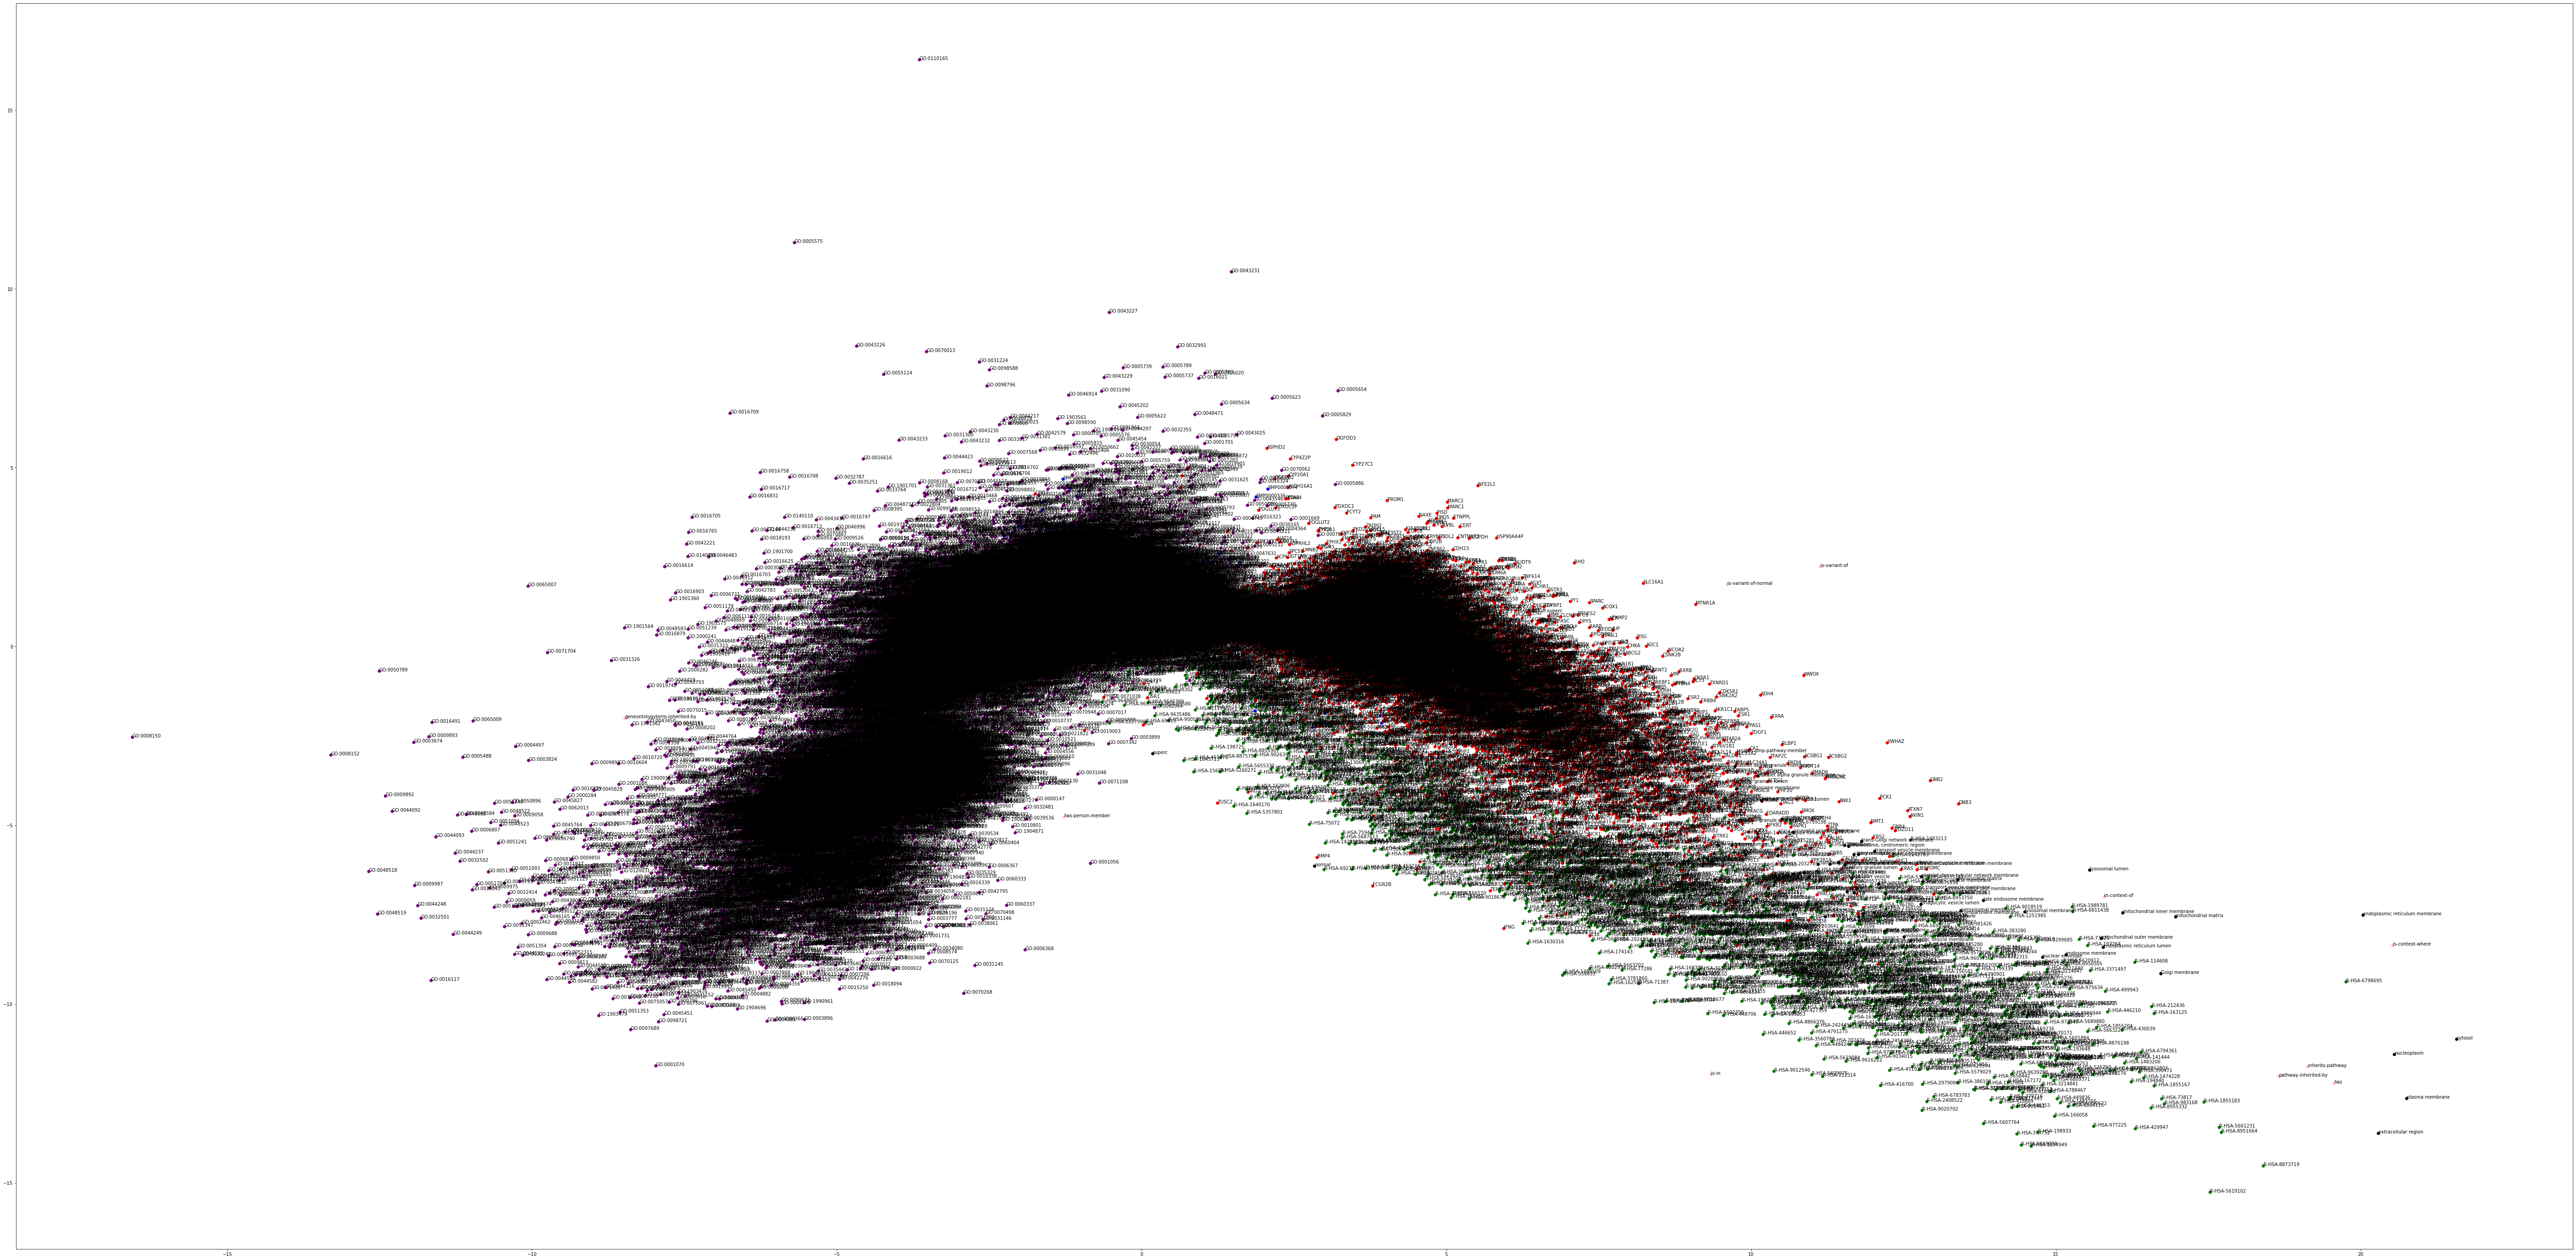

In [36]:
import matplotlib
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1], c=labels, cmap=matplotlib.colors.ListedColormap(colors))
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [37]:
model.most_similar("cytosol")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('ciliary base', 0.7721893787384033),
 ('clathrin-sculpted gamma-aminobutyric acid transport vesicle membrane',
  0.7452496886253357),
 ('chromosome', 0.7430424094200134),
 ('endosome', 0.7427271604537964),
 ('endosome membrane', 0.7415716648101807),
 ('autophagosome membrane', 0.7378688454627991),
 ('axonemal microtubule', 0.7324237823486328),
 ('mitochondrial outer membrane', 0.7317783832550049),
 ('Golgi-associated vesicle membrane', 0.731705904006958),
 ('cytoplasmic vesicle membrane', 0.7316294312477112)]

In [38]:
model.most_similar(positive=['superc'], negative=['normal'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('3:86123031_G/C', 0.5323147773742676),
 ('is-variant-of-superc', 0.4033512473106384),
 ('superc5', 0.3961394727230072),
 ('superc3', 0.3754380941390991),
 ('superc21', 0.3701316714286804),
 ('7:140404746_C/T', 0.3650543987751007),
 ('superc26', 0.3602977991104126),
 ('16:4740785_A/C', 0.35469138622283936),
 ('superc7', 0.3500387370586395),
 ('superc10', 0.3478095531463623)]

In [39]:
model.most_similar("superc")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('superc26', 0.6965356469154358),
 ('superc13', 0.6852301359176636),
 ('superc21', 0.6832118034362793),
 ('superc11', 0.6814570426940918),
 ('superc6', 0.6812880635261536),
 ('superc10', 0.6768783330917358),
 ('superc7', 0.6727138757705688),
 ('4:7103551_C/T', 0.6661730408668518),
 ('superc23', 0.6587390899658203),
 ('superc12', 0.6573373079299927)]

In [40]:
#+b cell differentiation, -t cell differentiation,+ t cell proliferation
model.most_similar(positive=['GO:0030183','GO:0042098'], negative=['GO:0030217'])
#first one should be GO:0042100, b cell proliferation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('GO:0042100', 0.7163534760475159),
 ('GO:0001923', 0.6176420450210571),
 ('GO:0042113', 0.6111096143722534),
 ('GO:0046651', 0.6042906641960144),
 ('GO:0001925', 0.5975728631019592),
 ('GO:0030101', 0.576178789138794),
 ('GO:0045578', 0.5758713483810425),
 ('GO:0045579', 0.5745095014572144),
 ('GO:0001926', 0.5740376114845276),
 ('GO:0030889', 0.5717651844024658)]

In [41]:
#+nucleus, +mitochondrial genome maintenence,-mitochondria
model.most_similar(positive=['GO:0005634','GO:0005739'], negative=['GO:0000002'])
#first one should be GO:0051276, nuclear genome maintenence

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('19:38074651_C/T', 0.5230407118797302),
 ('GO:0005654', 0.5203518867492676),
 ('GO:0005737', 0.47116363048553467),
 ('GO:0033009', 0.4708489775657654),
 ('ZNF326', 0.46161359548568726),
 ('19:38055480_T/G', 0.45939669013023376),
 ('GO:0070074', 0.4555074870586395),
 ('GO:0044227', 0.45225316286087036),
 ('GO:0042566', 0.45162826776504517),
 ('GO:0032047', 0.45079874992370605)]

In [42]:
#+nucleus, +mitochondrial genome maintenence,-mitochondria
model.most_similar(positive=['GO:0005634','GO:0000002'], negative=['GO:0005739'])
#first one should be GO:0051276, nuclear genome maintenence

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('GO:0000790', 0.5810399055480957),
 ('GO:0000978', 0.5613728761672974),
 ('GO:0001228', 0.5571907758712769),
 ('GO:0031052', 0.5567561388015747),
 ('GO:0043565', 0.5560356378555298),
 ('GO:0000981', 0.5251001119613647),
 ('GO:0035861', 0.5243920683860779),
 ('GO:0001673', 0.5149987936019897),
 ('GO:0000979', 0.5138280987739563),
 ('GO:0006974', 0.5107284784317017)]

In [43]:
#+nuclear transcription factor complex, +mitochondrial genome maintenence,-mitochondrian transcription
model.most_similar(positive=['GO:0044798','GO:0000002'], negative=['GO:0006390'])
#first one should be GO:0051276, nuclear genome maintenence

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('GO:0033955', 0.5371121764183044),
 ('GO:0090576', 0.5289213061332703),
 ('GO:0090578', 0.5139983296394348),
 ('GO:1903699', 0.47569066286087036),
 ('GO:0090577', 0.4685536324977875),
 ('GO:0048733', 0.46546676754951477),
 ('GO:0071149', 0.45607760548591614),
 ('GO:0044797', 0.4417895972728729),
 ('GO:0060487', 0.4403539299964905),
 ('GO:0016154', 0.43544918298721313)]

In [44]:
genemembers = {}
for sentence in phrases:
    if sentence[1] == 'has-gene-ontology-member':
        if sentence[0] not in genemembers:
            genemembers[sentence[0]] = set()
        genemembers[sentence[0]].add(sentence[2])

In [45]:
gomembers = {}
for sentence in phrases:
    if sentence[1]=='geneontologyterm-inherited-by':
        if sentence[0] not in gomembers:
            gomembers[sentence[0]] = set()
        gomembers[sentence[0]].add(sentence[2])

In [46]:
import pandas as pd
infodf = pd.read_csv("csv/agingGOterms.csv")

In [47]:
aging_goterms= list(infodf["GOID"])

In [48]:
aging_goterms

['GO:0001300',
 'GO:0001301',
 'GO:0001302',
 'GO:0001303',
 'GO:0001304',
 'GO:0001305',
 'GO:0001307',
 'GO:0001308',
 'GO:0001310',
 'GO:0001311',
 'GO:0001312',
 'GO:0001313',
 'GO:0001314',
 'GO:0001316',
 'GO:0001317',
 'GO:0001318',
 'GO:0001319',
 'GO:0001320',
 'GO:0001321',
 'GO:0001322',
 'GO:0001323',
 'GO:0001324',
 'GO:0006323',
 'GO:0007568',
 'GO:0007569',
 'GO:0007580',
 'GO:0010259',
 'GO:0010978',
 'GO:0019072',
 'GO:0019073',
 'GO:0019074',
 'GO:0034652',
 'GO:0035177',
 'GO:0036385',
 'GO:0036386',
 'GO:0039631',
 'GO:0039632',
 'GO:0044815',
 'GO:0060756',
 'GO:0060757',
 'GO:0060758',
 'GO:0061434',
 'GO:0090139',
 'GO:0090342',
 'GO:0090343',
 'GO:0090344',
 'GO:0098006',
 'GO:0098035',
 'GO:0098036',
 'GO:0098037',
 'GO:1900007',
 'GO:1900008',
 'GO:1900009',
 'GO:1900062',
 'GO:1900160',
 'GO:1903368',
 'GO:1903369',
 'GO:1903370',
 'GO:1905137',
 'GO:1905138']

In [49]:
#each gene onotlogy term as measured by the genes

def compute_simularity_ratios(genemembers):
    num_first =0
    top_ten = 0
    total = 0
    num_first_aging = 0
    top_ten_aging = 0
    total_aging = 0

    for ontology_term, gene_children in genemembers.items() :
        children = list(gene_children)
        if all(gene in model.wv.vocab for gene in children):
            simlist = model.most_similar(positive=children)
            if len (simlist) >0:
                total +=1
                if ontology_term in aging_goterms:
                    total_aging +=1
                if simlist[0][0]==ontology_term:
                    num_first += 1
                    if ontology_term in aging_goterms:
                        num_first_aging +=1
                is_in_top_ten = False
                for tup in simlist:
                    if tup[0]==ontology_term:
                        is_in_top_ten = True 
                if is_in_top_ten:
                    if ontology_term in aging_goterms:
                        top_ten_aging +=1
                    top_ten += 1

    ratio_in_top_ten= top_ten/total if total !=0 else 0
    ratio_first= num_first/total if total !=0 else 0
    ratio_in_top_ten_aging= top_ten_aging/total_aging if total_aging !=0 else 0
    ratio_first_aging= num_first_aging/total_aging if total_aging !=0 else 0
    return (ratio_first,ratio_in_top_ten,ratio_first_aging,ratio_in_top_ten_aging)

In [50]:
ratio_first, ratio_in_top_ten ,ratio_first_aging, ratio_in_top_ten_aging = compute_simularity_ratios(genemembers)
print ("Ratio of gene ontology terms that are closest to sum of gene children is {0}".format(ratio_first))
print ("Ratio of gene ontology terms that are top ten closest to sum of gene children is {0}".format(ratio_in_top_ten))
print ("Ratio of aging gene ontology terms that are closest to sum of gene children is {0}".format(ratio_first_aging))
print ("Ratio of aging gene ontology terms that are top ten closest to sum of gene children is {0}".format(ratio_in_top_ten_aging))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


Ratio of gene ontology terms that are closest to sum of gene children is 0.07708779443254818
Ratio of gene ontology terms that are top ten closest to sum of gene children is 0.24526437160270137
Ratio of aging gene ontology terms that are closest to sum of gene children is 0.1
Ratio of aging gene ontology terms that are top ten closest to sum of gene children is 0.2


In [51]:
#each gene onotlogy term as measured by child ontology terms
ratio_first1, ratio_in_top_ten1 ,ratio_first_aging1, ratio_in_top_ten_aging1 = compute_simularity_ratios(gomembers)
print ("Ratio of gene ontology terms that are closest to sum of gene ontology term children is {0}".format(ratio_first1))
print ("Ratio of gene ontology terms that are top ten closest to sum of gene ontology term children is {0}".format(ratio_in_top_ten1))
print ("Ratio of aging gene ontology terms that are closest to sum of gene ontology term children is {0}".format(ratio_first_aging1))
print ("Ratio of aging gene ontology terms that are top ten closest to sum of gene ontology term children is {0}".format(ratio_in_top_ten_aging1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


Ratio of gene ontology terms that are closest to sum of gene ontology term children is 0.6202553685432385
Ratio of gene ontology terms that are top ten closest to sum of gene ontology term children is 0.9485780615206036
Ratio of aging gene ontology terms that are closest to sum of gene ontology term children is 0.6538461538461539
Ratio of aging gene ontology terms that are top ten closest to sum of gene ontology term children is 1.0


In [52]:
len(model.wv.vocab)

110010

In [53]:
model.most_similar(positive=supercpersonlist)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('4:100562303_A/T', 0.7528520822525024),
 ('16:21666316_A/G', 0.7269026041030884),
 ('normal104', 0.7157158851623535),
 ('14:102256062_G/C', 0.7127101421356201),
 ('14:23299915_T/G', 0.7074522972106934),
 ('normal449', 0.703201174736023),
 ('normal394', 0.7031644582748413),
 ('superc-has-variant', 0.7028073668479919),
 ('normal42', 0.7013749480247498),
 ('normal231', 0.700951099395752)]

In [54]:
model.most_similar("inhibits")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


KeyError: "word 'inhibits' not in vocabulary"

In [55]:
# JJJ
#+b cell differentiation, -t cell differentiation, + t cell proliferation
model.most_similar(positive=['GO:0030183','GO:0042098'], negative=['GO:0030217'])
#first one should be GO:0042100, b cell proliferation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('GO:0042100', 0.7163534760475159),
 ('GO:0001923', 0.6176420450210571),
 ('GO:0042113', 0.6111096143722534),
 ('GO:0046651', 0.6042906641960144),
 ('GO:0001925', 0.5975728631019592),
 ('GO:0030101', 0.576178789138794),
 ('GO:0045578', 0.5758713483810425),
 ('GO:0045579', 0.5745095014572144),
 ('GO:0001926', 0.5740376114845276),
 ('GO:0030889', 0.5717651844024658)]

In [57]:
# JJJ
# Output all the GOs in the model (in form of GO-pairs) to a file named "dw_pairs.txt"
go_vocabs = []
go_pairs = []
f = open("dw_pairs.txt", "w")
for v in model.wv.vocab:
    if v.startswith("GO:"):
        go_vocabs.append(v)

i = 0
while (i + 1) < len(go_vocabs):
    f.write(go_vocabs[i] + "," + go_vocabs[i+1] + "\n")
    i = i + 2

f.close()

In [58]:
# JJJ
# Calculate the similarity values for the GO-pairs in "dw_pairs.txt"

f1 = open("dw_pairs.txt", "r")
lines = f1.readlines()

f2 = open("dw_results_all.txt", "w")

for line in lines:
    # print("Reading: {}".format(line))
    gos = line.split(",")
    go1 = gos[0].strip()
    go2 = gos[1].strip()
    go_similarity = model.similarity(go1, go2)
    print("Similarity between {} and {} is {}\n".format(go1, go2, go_similarity))
    f2.write("{},{},{}\n".format(go1, go2, go_similarity))

f1.close()
f2.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


Similarity between GO:0018471 and GO:0016709 is 0.49656862020492554

Similarity between GO:0004497 and GO:0032770 is 0.4139860272407532

Similarity between GO:0102291 and GO:0047090 is 0.9335014820098877

Similarity between GO:0032769 and GO:0032772 is 0.6306743621826172

Similarity between GO:0004503 and GO:0032773 is 0.7098196148872375

Similarity between GO:0044331 and GO:1900072 is 0.2041783630847931

Similarity between GO:0061426 and GO:0045944 is 0.5067263841629028

Similarity between GO:1904586 and GO:1904585 is 0.8942704796791077

Similarity between GO:0010243 and GO:0031100 is 0.3397376537322998

Similarity between GO:0010883 and GO:0010889 is 0.8516183495521545

Similarity between GO:1905952 and GO:0032368 is 0.6663792133331299

Similarity between GO:0045665 and GO:1902870 is 0.7290416359901428

Similarity between GO:0047049 and GO:0016616 is 0.6252219080924988

Similarity between GO:0016614 and GO:0016491 is 0.44486522674560547

Similarity between GO:0046992 and GO:0051353 i

Similarity between GO:0010033 and GO:0042221 is 0.29901036620140076

Similarity between GO:0033943 and GO:0015925 is 0.8901770114898682

Similarity between GO:0033921 and GO:0033930 is 0.9681594967842102

Similarity between GO:0033920 and GO:0015956 is 0.2993035316467285

Similarity between GO:0015957 and GO:0009165 is 0.599558413028717

Similarity between GO:0030810 and GO:1905014 is 0.8649320006370544

Similarity between GO:0034354 and GO:0034627 is 0.6930631399154663

Similarity between GO:0007487 and GO:0051094 is 0.19878113269805908

Similarity between GO:1903708 and GO:2000394 is 0.5250145196914673

Similarity between GO:0005925 and GO:0009921 is -0.03169988840818405

Similarity between GO:0030964 and GO:1904813 is -0.006136029493063688

Similarity between GO:0034705 and GO:0008076 is 0.7781540155410767

Similarity between GO:0071199 and GO:0051260 is 0.21750372648239136

Similarity between GO:0032463 and GO:2000065 is 0.27865883708000183

Similarity between GO:0001649 and GO:004

Similarity between GO:0046880 and GO:0061029 is 0.28504806756973267

Similarity between GO:0048468 and GO:0072142 is 0.6862369775772095

Similarity between GO:0072252 and GO:0032777 is 0.09501610696315765

Similarity between GO:0033255 and GO:0045814 is 0.2919619679450989

Similarity between GO:0006342 and GO:0031936 is 0.7603503465652466

Similarity between GO:1900635 and GO:1900900 is 0.8862536549568176

Similarity between GO:0031324 and GO:0045922 is 0.5414201617240906

Similarity between GO:0006631 and GO:0009106 is 0.3997473418712616

Similarity between GO:0006732 and GO:0051198 is 0.7871984839439392

Similarity between GO:1905013 and GO:1990082 is 0.18454881012439728

Similarity between GO:1990078 and GO:1990085 is 0.8667343258857727

Similarity between GO:0047135 and GO:0016668 is 0.8445912599563599

Similarity between GO:0050451 and GO:0098622 is 0.9660415053367615

Similarity between GO:0016667 and GO:0097040 is 0.2859116494655609

Similarity between GO:0042845 and GO:0008610 

Similarity between GO:1902345 and GO:0098993 is 0.10817118734121323

Similarity between GO:0045284 and GO:0045283 is 0.9610303044319153

Similarity between GO:0098803 and GO:0045277 is 0.810332179069519

Similarity between GO:0005751 and GO:0062079 is 0.1730489283800125

Similarity between GO:0010801 and GO:0018107 is 0.7361630201339722

Similarity between GO:0018210 and GO:0018195 is 0.46560510993003845

Similarity between GO:0036527 and GO:0052075 is 0.14637623727321625

Similarity between GO:0052391 and GO:0052200 is 0.6136826872825623

Similarity between GO:0052089 and GO:0018948 is 0.182329922914505

Similarity between GO:0018918 and GO:0018958 is 0.6245217323303223

Similarity between GO:0042403 and GO:0042404 is 0.8361004590988159

Similarity between GO:0018108 and GO:0007260 is 0.7517147064208984

Similarity between GO:0042531 and GO:0047195 is -0.08042023330926895

Similarity between GO:0008374 and GO:0001609 is 0.1202034056186676

Similarity between GO:0048678 and GO:0009611 

Similarity between GO:0046135 and GO:0072529 is 0.7313029170036316

Similarity between GO:0005476 and GO:0015491 is 0.8257854580879211

Similarity between GO:0048935 and GO:0048666 is 0.7551795244216919

Similarity between GO:0060119 and GO:0071248 is 0.2111043781042099

Similarity between GO:0030291 and GO:0045117 is -0.18931947648525238

Similarity between GO:0089704 and GO:0006855 is 0.6546342372894287

Similarity between GO:1904556 and GO:0102777 is 0.09066510200500488

Similarity between GO:0036155 and GO:0036154 is 0.7894624471664429

Similarity between GO:0046339 and GO:0006639 is 0.8089842200279236

Similarity between GO:0006638 and GO:0046460 is 0.74518221616745

Similarity between GO:1900339 and GO:1900341 is 0.8134344220161438

Similarity between GO:2001127 and GO:0015948 is 0.677066445350647

Similarity between GO:0043447 and GO:0009061 is 0.42046770453453064

Similarity between GO:0002006 and GO:0003084 is 0.8368957042694092

Similarity between GO:0002017 and GO:0055078 is

Similarity between GO:1904562 and GO:0046488 is 0.8113717436790466

Similarity between GO:1902633 and GO:0046446 is 0.30684903264045715

Similarity between GO:0009711 and GO:0072522 is 0.7864410877227783

Similarity between GO:0044271 and GO:0034641 is 0.602168619632721

Similarity between GO:0006090 and GO:0044541 is 0.19540628790855408

Similarity between GO:0044542 and GO:0031639 is 0.7442200183868408

Similarity between GO:0010756 and GO:0010954 is 0.7812533974647522

Similarity between GO:0045862 and GO:1903052 is 0.6858429312705994

Similarity between GO:0043042 and GO:0043041 is 0.8825972080230713

Similarity between GO:0043040 and GO:0140077 is 0.17080792784690857

Similarity between GO:0051222 and GO:2000397 is 0.7117193341255188

Similarity between GO:0045807 and GO:0044546 is 0.2844146490097046

Similarity between GO:0050608 and GO:0008863 is 0.958197295665741

Similarity between GO:0055036 and GO:0042317 is 0.10214873403310776

Similarity between GO:0044273 and GO:0031331 i

Similarity between GO:2000712 and GO:2000713 is 0.8044810891151428

Similarity between GO:0034095 and GO:2000710 is 0.9331801533699036

Similarity between GO:0035875 and GO:0034092 is 0.797021746635437

Similarity between GO:0034086 and GO:0034093 is 0.8480685949325562

Similarity between GO:0034091 and GO:1902233 is 0.08515501022338867

Similarity between GO:0033085 and GO:0045581 is 0.7484308481216431

Similarity between GO:2000175 and GO:2000174 is 0.8145050406455994

Similarity between GO:0045580 and GO:0050863 is 0.598974883556366

Similarity between GO:0051249 and GO:0002694 is 0.7443261742591858

Similarity between GO:0050865 and GO:0015760 is 0.04375104978680611

Similarity between GO:0004467 and GO:0002611 is -0.09817232936620712

Similarity between GO:0002470 and GO:0032698 is 0.4407416880130768

Similarity between GO:0032618 and GO:0035639 is -0.08074281364679337

Similarity between GO:0060974 and GO:0035050 is 0.39301082491874695

Similarity between GO:0035295 and GO:004216

Similarity between GO:0097297 and GO:0097200 is 0.6943346261978149

Similarity between GO:0097153 and GO:0043280 is 0.7375054359436035

Similarity between GO:2000332 and GO:2000335 is 0.9144343733787537

Similarity between GO:0000822 and GO:0043178 is 0.6982421278953552

Similarity between GO:1903878 and GO:0048046 is 0.2115711122751236

Similarity between GO:0061204 and GO:0061203 is 0.9680007100105286

Similarity between GO:2001013 and GO:0061331 is 0.9227122664451599

Similarity between GO:0005980 and GO:0045818 is 0.7282288074493408

Similarity between GO:0005977 and GO:0005978 is 0.8260265588760376

Similarity between GO:0009250 and GO:0003108 is 0.13162274658679962

Similarity between GO:0016939 and GO:0031616 is 0.3162132501602173

Similarity between GO:0034451 and GO:1903589 is 0.07682229578495026

Similarity between GO:0045692 and GO:0042813 is -0.1331540197134018

Similarity between GO:0009104 and GO:0044242 is 0.647429883480072

Similarity between GO:0097384 and GO:0051055 i

Similarity between GO:0098637 and GO:0090733 is 0.9329683184623718

Similarity between GO:0045425 and GO:0000968 is -0.037554819136857986

Similarity between GO:0000378 and GO:0032075 is 0.344139039516449

Similarity between GO:0070989 and GO:0006788 is 0.4386086165904999

Similarity between GO:0009607 and GO:0051968 is 0.25975513458251953

Similarity between GO:0050806 and GO:0014064 is 0.5888636112213135

Similarity between GO:0102177 and GO:0007107 is 0.12546858191490173

Similarity between GO:1902621 and GO:0086087 is 0.048285793513059616

Similarity between GO:0051393 and GO:0048477 is 0.017823167145252228

Similarity between GO:1905881 and GO:0045594 is 0.7940034866333008

Similarity between GO:0045592 and GO:0021881 is 0.11636385321617126

Similarity between GO:1905114 and GO:0110135 is 0.7269851565361023

Similarity between GO:1902856 and GO:1905515 is 0.8275866508483887

Similarity between GO:2000535 and GO:0015485 is 0.10889100283384323

Similarity between GO:0002906 and GO:0

Similarity between GO:0031312 and GO:0098922 is 0.7770923376083374

Similarity between GO:0098674 and GO:0097489 is 0.20022746920585632

Similarity between GO:0031983 and GO:1904579 is 0.08783125132322311

Similarity between GO:0080026 and GO:0039691 is 0.004978738259524107

Similarity between GO:0032019 and GO:0046915 is 0.3108900785446167

Similarity between GO:0046873 and GO:1990523 is 0.032879505306482315

Similarity between GO:0044573 and GO:0018291 is 0.8196320533752441

Similarity between GO:0018290 and GO:0018283 is 0.8009925484657288

Similarity between GO:0017006 and GO:0008938 is 0.12383551895618439

Similarity between GO:0019556 and GO:0072747 is 0.0673200860619545

Similarity between GO:1904843 and GO:0006272 is 0.30723169445991516

Similarity between GO:1903460 and GO:1902983 is 0.9087387323379517

Similarity between GO:0034088 and GO:0050813 is -0.003286916995421052

Similarity between GO:0050814 and GO:0033068 is 0.8220283389091492

Similarity between GO:1901730 and GO:

Similarity between GO:0016813 and GO:1905417 is 0.10283079743385315

Similarity between GO:0090220 and GO:0061948 is 0.3246961832046509

Similarity between GO:2001296 and GO:2000845 is -0.12324178963899612

Similarity between GO:0005154 and GO:0008317 is 0.825115978717804

Similarity between GO:0070543 and GO:0071399 is 0.9052099585533142

Similarity between GO:0071398 and GO:0032221 is 0.12218399345874786

Similarity between GO:0070822 and GO:0034348 is 0.19824880361557007

Similarity between GO:0038131 and GO:0004984 is 0.35841232538223267

Similarity between GO:0060089 and GO:0044332 is 0.17250654101371765

Similarity between GO:2000055 and GO:2000054 is 0.6928131580352783

Similarity between GO:1903489 and GO:1902895 is 0.43777549266815186

Similarity between GO:0075199 and GO:0075197 is 0.8730257153511047

Similarity between GO:0075200 and GO:0033239 is 0.4742518365383148

Similarity between GO:0019331 and GO:0072521 is 0.5793217420578003

Similarity between GO:0046415 and GO:0034

Similarity between GO:1903206 and GO:0050760 is 0.16082638502120972

Similarity between GO:0050757 and GO:0050759 is 0.8902022242546082

Similarity between GO:0051767 and GO:0051770 is 0.7344622611999512

Similarity between GO:0008179 and GO:0010996 is 0.18220922350883484

Similarity between GO:0015301 and GO:0070909 is 0.6844781637191772

Similarity between GO:0015291 and GO:0015514 is 0.7355549931526184

Similarity between GO:0010859 and GO:0008234 is 0.7001712322235107

Similarity between GO:0004197 and GO:0004198 is 0.6879285573959351

Similarity between GO:0097199 and GO:0038120 is 0.028851710259914398

Similarity between GO:0021607 and GO:0021602 is 0.8076042532920837

Similarity between GO:0050064 and GO:1904225 is 0.4955706298351288

Similarity between GO:0018715 and GO:0002254 is 0.07511947304010391

Similarity between GO:0002257 and GO:0002546 is 0.9442423582077026

Similarity between GO:0002382 and GO:0002256 is 0.934664785861969

Similarity between GO:0002549 and GO:0030144

Similarity between GO:0015119 and GO:0015526 is 0.9346017241477966

Similarity between GO:0061513 and GO:0017119 is 0.10390591621398926

Similarity between GO:0032951 and GO:0006417 is 0.2977522313594818

Similarity between GO:0090093 and GO:0032188 is 0.3273031413555145

Similarity between GO:1903486 and GO:0032187 is 0.7473833560943604

Similarity between GO:1901650 and GO:0051228 is 0.4998459815979004

Similarity between GO:1904687 and GO:0051230 is 0.6957496404647827

Similarity between GO:0007051 and GO:0043972 is 0.18981388211250305

Similarity between GO:0043966 and GO:0072595 is 0.24196110665798187

Similarity between GO:0072658 and GO:0072660 is 0.9056171774864197

Similarity between GO:0030018 and GO:0004793 is 0.0641821101307869

Similarity between GO:0050014 and GO:0060018 is 0.1023080125451088

Similarity between GO:0021781 and GO:0009383 is 0.1075877845287323

Similarity between GO:1990088 and GO:0102526 is 0.9698294401168823

Similarity between GO:0042086 and GO:0071857 

Similarity between GO:0046066 and GO:0009151 is 0.8644699454307556

Similarity between GO:0015931 and GO:1905700 is 0.3477940857410431

Similarity between GO:0040004 and GO:0046662 is 0.30125004053115845

Similarity between GO:0045712 and GO:0007433 is 0.9011659026145935

Similarity between GO:0045710 and GO:0102316 is 0.24825197458267212

Similarity between GO:0016682 and GO:0016679 is 0.8443096280097961

Similarity between GO:0030613 and GO:0050522 is 0.7263573408126831

Similarity between GO:0051646 and GO:1902581 is 0.24828346073627472

Similarity between GO:1902594 and GO:0051170 is 0.7192169427871704

Similarity between GO:0034974 and GO:0051603 is 0.0343901626765728

Similarity between GO:0052495 and GO:0072161 is 0.2670500874519348

Similarity between GO:0072202 and GO:0071391 is 0.22102022171020508

Similarity between GO:1903982 and GO:0032532 is 0.8596457242965698

Similarity between GO:0032530 and GO:0032534 is 0.8057723045349121

Similarity between GO:0090091 and GO:0098786

Similarity between GO:0030673 and GO:0072363 is 0.07920617610216141

Similarity between GO:0005104 and GO:0071472 is -0.02061518467962742

Similarity between GO:0071473 and GO:0061416 is 0.7372138500213623

Similarity between GO:0061392 and GO:0061393 is 0.9385958909988403

Similarity between GO:0061401 and GO:0001986 is 0.27901995182037354

Similarity between GO:0060281 and GO:2000061 is 0.4393726587295532

Similarity between GO:1905899 and GO:1901861 is 0.8503167033195496

Similarity between GO:0102822 and GO:0102439 is 0.9601524472236633

Similarity between GO:0060026 and GO:0060028 is 0.6301779747009277

Similarity between GO:1901234 and GO:1901233 is 0.6872522234916687

Similarity between GO:1904128 and GO:1905331 is 0.7234858274459839

Similarity between GO:1901208 and GO:0031731 is -0.123233363032341

Similarity between GO:1990858 and GO:1990840 is 0.9845637083053589

Similarity between GO:0002833 and GO:0002760 is 0.7357402443885803

Similarity between GO:0002803 and GO:0016235

Similarity between GO:0017057 and GO:0031973 is 0.20749913156032562

Similarity between GO:0009529 and GO:0036014 is 0.9530899524688721

Similarity between GO:0031972 and GO:1902138 is 0.2497757524251938

Similarity between GO:0006709 and GO:0000973 is 0.13911406695842743

Similarity between GO:1900089 and GO:0062128 is 0.0007138444343581796

Similarity between GO:0021506 and GO:0002039 is -0.03596262261271477

Similarity between GO:0070734 and GO:0072195 is 0.37186092138290405

Similarity between GO:0071715 and GO:0071717 is 0.9030904173851013

Similarity between GO:0071721 and GO:0071718 is 0.9654840230941772

Similarity between GO:1905422 and GO:0035187 is 0.03920377790927887

Similarity between GO:0002209 and GO:0045486 is 0.13101686537265778

Similarity between GO:0046566 and GO:0008303 is 0.5056405067443848

Similarity between GO:0110158 and GO:0061672 is 0.8067383766174316

Similarity between GO:1904284 and GO:0002589 is 0.7672300338745117

Similarity between GO:0002583 and GO:0

Similarity between GO:0002425 and GO:0002422 is 0.9735430479049683

Similarity between GO:0055025 and GO:0043209 is 0.14102089405059814

Similarity between GO:0047212 and GO:1990482 is 0.75044846534729

Similarity between GO:0033716 and GO:0047731 is 0.9625210165977478

Similarity between GO:0050593 and GO:0032872 is 0.009183159098029137

Similarity between GO:0035507 and GO:0035304 is 0.5939503312110901

Similarity between GO:0035306 and GO:0051174 is 0.3163275718688965

Similarity between GO:0008035 and GO:1900890 is -0.003001157194375992

Similarity between GO:0047563 and GO:0097267 is 0.19726519286632538

Similarity between GO:0032496 and GO:0032497 is 0.7073705196380615

Similarity between GO:0032490 and GO:0003140 is 0.03633255138993263

Similarity between GO:0003154 and GO:1900094 is 0.8588080406188965

Similarity between GO:0038107 and GO:0007323 is 0.1915014237165451

Similarity between GO:2000873 and GO:1904506 is 0.43863871693611145

Similarity between GO:0033065 and GO:0033

Similarity between GO:0045080 and GO:0032736 is 0.47103843092918396

Similarity between GO:1904009 and GO:0032849 is 0.11172289401292801

Similarity between GO:1905474 and GO:0002142 is 0.15950526297092438

Similarity between GO:0035655 and GO:2000494 is 0.7984292507171631

Similarity between GO:2000217 and GO:0036187 is 0.8961352109909058

Similarity between GO:0047453 and GO:0004655 is 0.4276670217514038

Similarity between GO:0003340 and GO:0014722 is 0.0160809513181448

Similarity between GO:0021808 and GO:1990814 is 0.12400132417678833

Similarity between GO:0047953 and GO:0033718 is 0.6381648778915405

Similarity between GO:0047904 and GO:0004941 is 0.15988793969154358

Similarity between GO:0061129 and GO:0043327 is 0.515007495880127

Similarity between GO:0102051 and GO:0043975 is 0.37266838550567627

Similarity between GO:2000616 and GO:1901462 is 0.07258426398038864

Similarity between GO:0019652 and GO:0019542 is 0.6071493029594421

Similarity between GO:0043441 and GO:00469

Similarity between GO:1903604 and GO:0035781 is 0.1315060704946518

Similarity between GO:1900063 and GO:0071750 is 0.09036681056022644

Similarity between GO:0071752 and GO:0035364 is -0.01977364718914032

Similarity between GO:1900275 and GO:0045894 is 0.02558382786810398

Similarity between GO:0007532 and GO:0002567 is 0.4323272705078125

Similarity between GO:0002200 and GO:0071305 is -0.10777734965085983

Similarity between GO:0097429 and GO:0047514 is 0.5606938004493713

Similarity between GO:0044728 and GO:0047237 is 0.07411521673202515

Similarity between GO:0060535 and GO:0060536 is 0.7895365953445435

Similarity between GO:0035262 and GO:0061040 is 0.8321323990821838

Similarity between GO:0048815 and GO:0043474 is 0.25164803862571716

Similarity between GO:0043324 and GO:0009511 is 0.2651149332523346

Similarity between GO:1903587 and GO:1903671 is 0.6843783259391785

Similarity between GO:0044066 and GO:0052183 is 0.7537521123886108

Similarity between GO:0052494 and GO:190

Similarity between GO:1903018 and GO:0044870 is 0.8272354006767273

Similarity between GO:0044788 and GO:0052428 is 0.6824944019317627

Similarity between GO:1990969 and GO:0016112 is 0.2051936239004135

Similarity between GO:2000143 and GO:0000310 is 0.02471977286040783

Similarity between GO:0009032 and GO:0051365 is 0.06840280443429947

Similarity between GO:0018447 and GO:0018700 is -0.12855345010757446

Similarity between GO:0071569 and GO:0090084 is 0.11661870777606964

Similarity between GO:0070841 and GO:1902988 is 0.8707597255706787

Similarity between GO:1902997 and GO:0015341 is 0.03392822667956352

Similarity between GO:0015759 and GO:0042948 is 0.9260699152946472

Similarity between GO:0047224 and GO:0140103 is 0.8154028058052063

Similarity between GO:0047399 and GO:0034504 is -0.201987162232399

Similarity between GO:0106032 and GO:0009982 is 0.8103317022323608

Similarity between GO:0048620 and GO:1902322 is 0.04252041503787041

Similarity between GO:1900500 and GO:0046

Similarity between GO:1900747 and GO:0090095 is 0.09579279273748398

Similarity between GO:0031357 and GO:0031353 is 0.9835577607154846

Similarity between GO:0031356 and GO:0031352 is 0.9749307632446289

Similarity between GO:0031859 and GO:2000267 is -0.06343786418437958

Similarity between GO:0030195 and GO:0010536 is 0.15365172922611237

Similarity between GO:0008942 and GO:0050460 is 0.9581200480461121

Similarity between GO:0018938 and GO:0046304 is 0.8879556059837341

Similarity between GO:1903205 and GO:2000776 is 0.1467241793870926

Similarity between GO:0042550 and GO:0050823 is 0.17347225546836853

Similarity between GO:0035921 and GO:0150147 is 0.8521245718002319

Similarity between GO:0150146 and GO:0120180 is 0.9229907393455505

Similarity between GO:0150115 and GO:0034330 is 0.8433172106742859

Similarity between GO:0047914 and GO:0050565 is 0.960974395275116

Similarity between GO:0033827 and GO:0009866 is -0.03748640418052673

Similarity between GO:0002218 and GO:19024

Similarity between GO:1900927 and GO:1905892 is 0.4815433919429779

Similarity between GO:0045651 and GO:0045649 is 0.6964922547340393

Similarity between GO:0052847 and GO:0052841 is 0.960831344127655

Similarity between GO:0052848 and GO:0009115 is 0.33988937735557556

Similarity between GO:0032626 and GO:1903768 is 0.06941131502389908

Similarity between GO:1903767 and GO:0008046 is 0.31296491622924805

Similarity between GO:0021921 and GO:2000177 is 0.8408406972885132

Similarity between GO:0008692 and GO:0050043 is 0.9682940244674683

Similarity between GO:0008809 and GO:0019821 is 0.3872997760772705

Similarity between GO:0140266 and GO:0097511 is 0.3190864026546478

Similarity between GO:0070314 and GO:1903451 is 0.8129396438598633

Similarity between GO:1903450 and GO:0071056 is 0.2479299008846283

Similarity between GO:0061779 and GO:0015920 is 0.03828880190849304

Similarity between GO:0015921 and GO:0001895 is 0.16441260278224945

Similarity between GO:0017022 and GO:0051803

Similarity between GO:2001202 and GO:0032666 is 0.22510112822055817

Similarity between GO:0032706 and GO:0031655 is 0.6288368105888367

Similarity between GO:0019271 and GO:0003935 is 0.34910786151885986

Similarity between GO:0044682 and GO:0042676 is 0.2288510948419571

Similarity between GO:0032784 and GO:0060110 is 0.06545773893594742

Similarity between GO:0046226 and GO:0046281 is 0.657192051410675

Similarity between GO:0009852 and GO:0102494 is 0.12024807929992676

Similarity between GO:0007266 and GO:0032488 is 0.7834345698356628

Similarity between GO:0035024 and GO:0007181 is 0.14254644513130188

Similarity between GO:0044615 and GO:0099065 is -0.028353920206427574

Similarity between GO:0051844 and GO:0051862 is 0.9857483506202698

Similarity between GO:0044486 and GO:2000141 is 0.2697271406650543

Similarity between GO:0032097 and GO:0070226 is 0.07055041939020157

Similarity between GO:0005871 and GO:0062051 is 0.21809838712215424

Similarity between GO:0061852 and GO:00

Similarity between GO:0030409 and GO:0009257 is 0.555414617061615

Similarity between GO:1901961 and GO:1901960 is 0.9456322193145752

Similarity between GO:1902696 and GO:1902485 is 0.3214571177959442

Similarity between GO:1904162 and GO:0016895 is 0.7827137112617493

Similarity between GO:0008852 and GO:1900802 is -0.03205541893839836

Similarity between GO:0098555 and GO:0098553 is 0.9633723497390747

Similarity between GO:0098558 and GO:0098575 is 0.538143515586853

Similarity between GO:0098570 and GO:0007298 is 0.0822807028889656

Similarity between GO:0046095 and GO:0008407 is 0.28873711824417114

Similarity between GO:0033628 and GO:0018664 is 0.17162851989269257

Similarity between GO:0102099 and GO:0090395 is 0.3406418561935425

Similarity between GO:0046075 and GO:0006235 is 0.8309496641159058

Similarity between GO:0031101 and GO:0043403 is 0.5646216869354248

Similarity between GO:0014730 and GO:1901741 is 0.25345149636268616

Similarity between GO:0014905 and GO:0045026 

Similarity between GO:0033608 and GO:0072048 is 0.17530085146427155

Similarity between GO:0032117 and GO:2000626 is 0.15050698816776276

Similarity between GO:0000491 and GO:1904786 is 0.0735972598195076

Similarity between GO:0035004 and GO:0043552 is 0.7521153688430786

Similarity between GO:0021525 and GO:0021522 is 0.8736570477485657

Similarity between GO:0007385 and GO:0035292 is 0.9650154113769531

Similarity between GO:0097507 and GO:0031473 is 0.16418257355690002

Similarity between GO:0033469 and GO:0021651 is 0.24070927500724792

Similarity between GO:0021593 and GO:0090303 is 0.10890690982341766

Similarity between GO:1905180 and GO:0034848 is 0.11863954365253448

Similarity between GO:0098610 and GO:0043706 is 0.8494353294372559

Similarity between GO:0019395 and GO:0034440 is 0.5291704535484314

Similarity between GO:2000464 and GO:1904567 is 0.14811256527900696

Similarity between GO:1900403 and GO:1904208 is 0.19668015837669373

Similarity between GO:0035926 and GO:004

Similarity between GO:1901045 and GO:0018991 is 0.8176716566085815

Similarity between GO:0060403 and GO:0110123 is 0.2915804386138916

Similarity between GO:0045639 and GO:1905321 is 0.20156484842300415

Similarity between GO:0033310 and GO:0009906 is 0.19768553972244263

Similarity between GO:0018245 and GO:0018241 is 0.8380438685417175

Similarity between GO:1904099 and GO:1904100 is 0.39442530274391174

Similarity between GO:0030410 and GO:0016072 is 0.12201357632875443

Similarity between GO:0001955 and GO:0060835 is 0.15663260221481323

Similarity between GO:0003277 and GO:0003278 is 0.8264212608337402

Similarity between GO:0030422 and GO:0010267 is 0.7088515162467957

Similarity between GO:2000630 and GO:0050975 is -0.019620323553681374

Similarity between GO:0072393 and GO:0021613 is 0.23149602115154266

Similarity between GO:0007199 and GO:2001271 is -0.04956677183508873

Similarity between GO:0072123 and GO:0072263 is 0.9538479447364807

Similarity between GO:0072262 and GO:

Similarity between GO:0120003 and GO:0015217 is 0.30039751529693604

Similarity between GO:0005471 and GO:1990157 is -0.05029667541384697

Similarity between GO:1990098 and GO:0009558 is 0.3519311547279358

Similarity between GO:0021509 and GO:0047993 is 0.19529902935028076

Similarity between GO:0042974 and GO:0005034 is 0.04261218011379242

Similarity between GO:0102185 and GO:0002889 is 0.09317196160554886

Similarity between GO:0072724 and GO:0072725 is 0.9402445554733276

Similarity between GO:0048356 and GO:0008209 is 0.2446616142988205

Similarity between GO:0097100 and GO:0002152 is 0.019511481747031212

Similarity between GO:1904253 and GO:0070859 is 0.8467820882797241

Similarity between GO:0009803 and GO:0045484 is 0.2090120017528534

Similarity between GO:0004633 and GO:0102577 is 0.5524910092353821

Similarity between GO:0004300 and GO:1900695 is 0.020957810804247856

Similarity between GO:0005832 and GO:0106073 is 0.2174336314201355

Similarity between GO:0045559 and GO:0

Similarity between GO:0072698 and GO:0043292 is 0.16114814579486847

Similarity between GO:0033448 and GO:0052028 is 0.3200088441371918

Similarity between GO:0050556 and GO:1902539 is 0.14684228599071503

Similarity between GO:0075510 and GO:0044417 is 0.5579516887664795

Similarity between GO:0046784 and GO:0009034 is -0.021661533042788506

Similarity between GO:0005432 and GO:0010262 is 0.0828530415892601

Similarity between GO:0009793 and GO:0039677 is 0.230585515499115

Similarity between GO:0039675 and GO:0046802 is 0.9719222784042358

Similarity between GO:0048486 and GO:2000992 is 0.14403167366981506

Similarity between GO:1903625 and GO:0006308 is 0.7729989886283875

Similarity between GO:0002274 and GO:0002366 is 0.620391309261322

Similarity between GO:0072629 and GO:0031392 is 0.14928342401981354

Similarity between GO:0010760 and GO:0001784 is 0.13207969069480896

Similarity between GO:1900220 and GO:0061472 is 0.059757594019174576

Similarity between GO:1903211 and GO:004

Similarity between GO:0071688 and GO:0071690 is 0.9358110427856445

Similarity between GO:0030241 and GO:0010898 is 0.09982161223888397

Similarity between GO:0004806 and GO:0035777 is -0.014053525403141975

Similarity between GO:0045769 and GO:0031166 is 0.13779716193675995

Similarity between GO:0008390 and GO:0018705 is 0.14931966364383698

Similarity between GO:0035733 and GO:1905121 is 0.011011350899934769

Similarity between GO:0051012 and GO:0018511 is 0.054052550345659256

Similarity between GO:0003865 and GO:0033765 is 0.822587788105011

Similarity between GO:0047568 and GO:0052839 is 0.2749388813972473

Similarity between GO:0102025 and GO:0015117 is 0.923645555973053

Similarity between GO:0061824 and GO:0106077 is 0.1026930958032608

Similarity between GO:1903346 and GO:2000547 is 0.17601391673088074

Similarity between GO:2000548 and GO:0071795 is -0.12358257174491882

Similarity between GO:0034432 and GO:0031409 is 0.013047691434621811

Similarity between GO:0009302 and G

Similarity between GO:0043691 and GO:0047844 is -0.0017988537438213825

Similarity between GO:0043723 and GO:0030107 is 0.16831906139850616

Similarity between GO:0032396 and GO:0032393 is 0.8749245405197144

Similarity between GO:0045543 and GO:0015516 is 0.2932487726211548

Similarity between GO:0097434 and GO:0015231 is 0.6119163632392883

Similarity between GO:1905673 and GO:0102982 is -0.008417275734245777

Similarity between GO:0035025 and GO:0099142 is 0.13483092188835144

Similarity between GO:1901585 and GO:1901586 is 0.719633162021637

Similarity between GO:0044736 and GO:0015280 is 0.7429050207138062

Similarity between GO:0110027 and GO:0008398 is 0.0008339593186974525

Similarity between GO:0051512 and GO:0060682 is 0.13180308043956757

Similarity between GO:0005017 and GO:1904007 is 0.1947486251592636

Similarity between GO:0099071 and GO:0062104 is 0.23676085472106934

Similarity between GO:0033407 and GO:0033413 is 0.9538935422897339

Similarity between GO:0033428 and G

Similarity between GO:0010263 and GO:0061605 is 0.08647032827138901

Similarity between GO:0071925 and GO:0045752 is 0.030821116641163826

Similarity between GO:0008592 and GO:0045751 is 0.7273444533348083

Similarity between GO:0032783 and GO:0030521 is 0.12832678854465485

Similarity between GO:0060766 and GO:0002917 is 0.13254602253437042

Similarity between GO:0006931 and GO:0002681 is 0.027063047513365746

Similarity between GO:0033153 and GO:0033151 is 0.8215627670288086

Similarity between GO:0006551 and GO:0035703 is 0.12308038771152496

Similarity between GO:2000438 and GO:0110095 is -0.12275449186563492

Similarity between GO:0007287 and GO:0021557 is 0.2058335691690445

Similarity between GO:0010712 and GO:0038143 is 0.1616576462984085

Similarity between GO:0042184 and GO:0042187 is 0.9170004725456238

Similarity between GO:0018951 and GO:0043468 is 0.16626399755477905

Similarity between GO:0062066 and GO:1900422 is 0.023328037932515144

Similarity between GO:0100037 and G

Similarity between GO:0060328 and GO:0000814 is 0.13489507138729095

Similarity between GO:0043541 and GO:2000398 is -0.01882246695458889

Similarity between GO:0016170 and GO:1990180 is -0.17610961198806763

Similarity between GO:0042780 and GO:0061639 is 0.024468030780553818

Similarity between GO:2001136 and GO:2000658 is -0.030965201556682587

Similarity between GO:0070410 and GO:1900364 is 0.24161404371261597

Similarity between GO:0097129 and GO:0097134 is 0.7941400408744812

Similarity between GO:0050512 and GO:0046959 is -0.05725935101509094

Similarity between GO:1905573 and GO:1905008 is 0.05397416651248932

Similarity between GO:0071203 and GO:0009188 is -0.09092894196510315

Similarity between GO:0009195 and GO:0009191 is 0.8380972743034363

Similarity between GO:0009140 and GO:0102446 is 0.2723139822483063

Similarity between GO:0048711 and GO:0046448 is -0.06696415692567825

Similarity between GO:1900913 and GO:0010850 is 0.12088120728731155

Similarity between GO:0002269

Similarity between GO:0042870 and GO:0090514 is 0.6974433064460754

Similarity between GO:0015828 and GO:0032763 is 0.24156390130519867

Similarity between GO:0001582 and GO:0018979 is 0.193104088306427

Similarity between GO:0021859 and GO:0031544 is 0.14508391916751862

Similarity between GO:0060399 and GO:0033424 is -0.03352789208292961

Similarity between GO:0033418 and GO:1903110 is 0.37413448095321655

Similarity between GO:1903111 and GO:1903112 is 0.7132916450500488

Similarity between GO:0140337 and GO:0120013 is 0.8600690364837646

Similarity between GO:0120016 and GO:0097307 is 0.11846249550580978

Similarity between GO:0097308 and GO:0051753 is 0.18106810748577118

Similarity between GO:0019187 and GO:0004578 is 0.9002110958099365

Similarity between GO:0047259 and GO:0033090 is 0.11893010884523392

Similarity between GO:0071758 and GO:1990713 is 0.1769326627254486

Similarity between GO:0047618 and GO:0031717 is 0.12010612338781357

Similarity between GO:0031784 and GO:003

Similarity between GO:2000722 and GO:0090213 is 0.4918701946735382

Similarity between GO:0018138 and GO:0071003 is 0.17561697959899902

Similarity between GO:0035100 and GO:0032935 is 0.8214304447174072

Similarity between GO:0038198 and GO:1901230 is 0.0104990778490901

Similarity between GO:0071770 and GO:0060189 is 0.009297141805291176

Similarity between GO:0002601 and GO:1990710 is 0.16621997952461243

Similarity between GO:0070581 and GO:0047186 is 0.011881359852850437

Similarity between GO:0032344 and GO:0061675 is 0.18286727368831635

Similarity between GO:0031893 and GO:0097392 is 0.20766568183898926

Similarity between GO:0035662 and GO:0072488 is 0.125435471534729

Similarity between GO:0048796 and GO:0034665 is 0.15730763971805573

Similarity between GO:0035355 and GO:1905868 is -0.04272773489356041

Similarity between GO:0140383 and GO:1902395 is 0.32450130581855774

Similarity between GO:0033616 and GO:0043461 is 0.9193041920661926

Similarity between GO:1902218 and GO:

Similarity between GO:0072670 and GO:1900864 is 0.8343836069107056

Similarity between GO:0000027 and GO:0051654 is 0.1245986744761467

Similarity between GO:0050074 and GO:1903243 is -0.05488116666674614

Similarity between GO:0010615 and GO:0098596 is 0.17417046427726746

Similarity between GO:0090320 and GO:0090069 is 0.2714845836162567

Similarity between GO:1902167 and GO:1990144 is 0.4289225935935974

Similarity between GO:0030382 and GO:1902991 is -0.002575220074504614

Similarity between GO:0051136 and GO:0018838 is 0.0914837121963501

Similarity between GO:0052795 and GO:1903016 is 0.5833852887153625

Similarity between GO:0044866 and GO:0047774 is 0.24760308861732483

Similarity between GO:0018519 and GO:0043775 is 0.27402377128601074

Similarity between GO:0006542 and GO:0098691 is 0.1424628496170044

Similarity between GO:0000481 and GO:0030757 is 0.20473162829875946

Similarity between GO:0102476 and GO:0102620 is 0.9435371160507202

Similarity between GO:0022023 and GO:01

Similarity between GO:0021956 and GO:0008589 is 0.41560840606689453

Similarity between GO:0071885 and GO:0045138 is -0.05573422461748123

Similarity between GO:1902482 and GO:0080017 is 0.35716381669044495

Similarity between GO:0097741 and GO:0019959 is 0.15844734013080597

Similarity between GO:1900183 and GO:1900834 is 0.9208638668060303

Similarity between GO:0010361 and GO:0010362 is 0.9695730805397034

Similarity between GO:0010359 and GO:0102696 is 0.29629093408584595

Similarity between GO:0035723 and GO:0008093 is 0.04838194698095322

Similarity between GO:0033110 and GO:0047951 is 0.2444131076335907

Similarity between GO:0072099 and GO:0035553 is -0.07080262154340744

Similarity between GO:2000994 and GO:0003866 is 0.02830960974097252

Similarity between GO:0071835 and GO:0071834 is 0.9763001203536987

Similarity between GO:1900112 and GO:1900113 is 0.7325239777565002

Similarity between GO:0086093 and GO:0086033 is 0.9468879699707031

Similarity between GO:0045228 and GO:0

Similarity between GO:1900873 and GO:1901938 is 0.5542208552360535

Similarity between GO:1901934 and GO:0060005 is 0.00808236375451088

Similarity between GO:0032843 and GO:0047141 is 0.968451738357544

Similarity between GO:0019142 and GO:0070103 is 0.25760728120803833

Similarity between GO:0002733 and GO:1902406 is 0.25670552253723145

Similarity between GO:0031566 and GO:0019458 is 0.15775632858276367

Similarity between GO:0009087 and GO:0006555 is 0.7812187075614929

Similarity between GO:1905351 and GO:1990773 is 0.09459372609853745

Similarity between GO:1904466 and GO:0048913 is -0.07479865103960037

Similarity between GO:0004912 and GO:0050167 is 0.03716323524713516

Similarity between GO:0071323 and GO:0034405 is 0.19411003589630127

Similarity between GO:0097702 and GO:0097704 is 0.937518298625946

Similarity between GO:0097706 and GO:0098928 is 0.2253904491662979

Similarity between GO:0034171 and GO:0071032 is 0.2436552792787552

Similarity between GO:0005851 and GO:0052

Similarity between GO:0052852 and GO:0002704 is 0.14954809844493866

Similarity between GO:1903483 and GO:0070067 is -0.2793651223182678

Similarity between GO:0070048 and GO:1905149 is 0.02855006791651249

Similarity between GO:0044677 and GO:2000142 is 0.03328076750040054

Similarity between GO:0048802 and GO:0021687 is 0.42608383297920227

Similarity between GO:0000053 and GO:0010630 is 0.13775019347667694

Similarity between GO:0047905 and GO:0052678 is 0.5637314915657043

Similarity between GO:0050011 and GO:0102879 is 0.3983708620071411

Similarity between GO:0045260 and GO:0021849 is -0.04724104702472687

Similarity between GO:1904820 and GO:1904817 is 0.9759629368782043

Similarity between GO:0016165 and GO:0018570 is 0.6737472414970398

Similarity between GO:0008810 and GO:0033923 is 0.9533593654632568

Similarity between GO:0033531 and GO:0050018 is 0.303682804107666

Similarity between GO:0033862 and GO:0009041 is 0.9357231855392456

Similarity between GO:2000751 and GO:0033

Similarity between GO:0070834 and GO:1904895 is 0.15912459790706635

Similarity between GO:1904902 and GO:0015243 is 0.25681254267692566

Similarity between GO:0001810 and GO:0033420 is 0.3489890396595001

Similarity between GO:0061682 and GO:0036311 is 0.2705861032009125

Similarity between GO:0051409 and GO:0045365 is 0.058748651295900345

Similarity between GO:0042540 and GO:1903516 is 0.18866018950939178

Similarity between GO:0002455 and GO:0009507 is -0.14433275163173676

Similarity between GO:0003174 and GO:0003171 is 0.9151766300201416

Similarity between GO:1902252 and GO:0050639 is 0.2908676862716675

Similarity between GO:0071024 and GO:0106153 is 0.2418149709701538

Similarity between GO:1901736 and GO:0020018 is 0.029876016080379486

Similarity between GO:1990893 and GO:0006003 is -0.057952046394348145

Similarity between GO:0019452 and GO:0009347 is 0.02495715394616127

Similarity between GO:0030153 and GO:0062075 is 0.3050813674926758

Similarity between GO:0052935 and G

Similarity between GO:0102363 and GO:0098736 is 0.01839442364871502

Similarity between GO:0045290 and GO:0102196 is 0.7623897790908813

Similarity between GO:1990447 and GO:0021559 is 0.192442387342453

Similarity between GO:0009589 and GO:0007604 is 0.9379819631576538

Similarity between GO:0050354 and GO:0099010 is 0.020108705386519432

Similarity between GO:0098885 and GO:0070060 is 0.43955424427986145

Similarity between GO:1905536 and GO:0050235 is 0.05229543522000313

Similarity between GO:1901790 and GO:0042217 is 0.7727948427200317

Similarity between GO:0032826 and GO:0015843 is 0.05031396076083183

Similarity between GO:0072489 and GO:0009868 is 0.3473045229911804

Similarity between GO:0047557 and GO:0048339 is 0.023010436445474625

Similarity between GO:0048055 and GO:0060963 is 0.17482616007328033

Similarity between GO:0010690 and GO:0008482 is 0.051942434161901474

Similarity between GO:0051068 and GO:0019558 is 0.3616107404232025

Similarity between GO:0062048 and GO:0

Similarity between GO:0072664 and GO:1990659 is 0.3770108222961426

Similarity between GO:0009506 and GO:0009550 is 0.9372938871383667

Similarity between GO:0005827 and GO:0032307 is -0.09701821208000183

Similarity between GO:1902775 and GO:0014852 is 0.06468464434146881

Similarity between GO:0055053 and GO:0015591 is 0.8304692506790161

Similarity between GO:0003418 and GO:0102794 is -0.06206387281417847

Similarity between GO:0044400 and GO:0050336 is 0.19708968698978424

Similarity between GO:1902360 and GO:0042773 is 0.2622283399105072

Similarity between GO:0042774 and GO:0045091 is -0.023777760565280914

Similarity between GO:0102655 and GO:0018592 is 0.5373430252075195

Similarity between GO:0039709 and GO:0019069 is 0.9074918627738953

Similarity between GO:0039708 and GO:0039711 is 0.9446014165878296

Similarity between GO:0106003 and GO:0033054 is -0.04835771396756172

Similarity between GO:0032563 and GO:0072031 is 0.06504909694194794

Similarity between GO:0072231 and GO

Similarity between GO:1990832 and GO:0043797 is 0.26364538073539734

Similarity between GO:0009920 and GO:0000919 is 0.9645503163337708

Similarity between GO:0071930 and GO:0090736 is 0.3284231126308441

Similarity between GO:0090365 and GO:0102590 is 0.13322003185749054

Similarity between GO:0004996 and GO:0060141 is 0.21718287467956543

Similarity between GO:0061503 and GO:0034829 is 0.7346636652946472

Similarity between GO:0098605 and GO:0090231 is 0.2129933089017868

Similarity between GO:0052686 and GO:0034538 is 0.4607837200164795

Similarity between GO:0050357 and GO:0045303 is 0.548742949962616

Similarity between GO:0097272 and GO:0103058 is 0.13904576003551483

Similarity between GO:0098966 and GO:0044726 is -0.15521223843097687

Similarity between GO:1901583 and GO:0035677 is 0.38778063654899597

Similarity between GO:0035503 and GO:0061916 is 0.24540279805660248

Similarity between GO:0030351 and GO:0051909 is 0.18220296502113342

Similarity between GO:2001270 and GO:000

Similarity between GO:0102318 and GO:0060594 is 0.12459824234247208

Similarity between GO:0033368 and GO:0097608 is 0.16144689917564392

Similarity between GO:0010709 and GO:0030491 is 0.9598438739776611

Similarity between GO:0150144 and GO:0150143 is 0.9375895261764526

Similarity between GO:0061735 and GO:0045053 is 0.3372568190097809

Similarity between GO:0006386 and GO:0018911 is -0.029033193364739418

Similarity between GO:0072378 and GO:0050964 is 0.03562018275260925

Similarity between GO:0005133 and GO:0071784 is 0.008747688494622707

Similarity between GO:0071783 and GO:0009695 is 0.0874074324965477

Similarity between GO:0070165 and GO:0036193 is -0.039268963038921356

Similarity between GO:0033094 and GO:0031121 is 0.24829016625881195

Similarity between GO:0061611 and GO:0102050 is 0.2374231368303299

Similarity between GO:0102049 and GO:0031321 is 0.2826686203479767

Similarity between GO:0034916 and GO:0080162 is 0.15503144264221191

Similarity between GO:0140209 and G

Similarity between GO:0098540 and GO:0098538 is 0.9830631017684937

Similarity between GO:0006667 and GO:0036521 is 0.2875596880912781

Similarity between GO:0097016 and GO:0102863 is -0.0794982984662056

Similarity between GO:0003075 and GO:0032286 is 0.025126803666353226

Similarity between GO:2000039 and GO:0030249 is -0.019326794892549515

Similarity between GO:0060370 and GO:1900105 is 0.029275987297296524

Similarity between GO:0036118 and GO:1902111 is 0.006930753588676453

Similarity between GO:0005300 and GO:0097558 is 0.2279239445924759

Similarity between GO:0046726 and GO:0062096 is 0.15339474380016327

Similarity between GO:0036441 and GO:0032750 is 0.14802241325378418

Similarity between GO:0101029 and GO:0102357 is 0.3394450545310974

Similarity between GO:0099115 and GO:0042888 is 0.3379264771938324

Similarity between GO:0090113 and GO:1901353 is 0.1492639183998108

Similarity between GO:0071582 and GO:0090337 is 0.1681070327758789

Similarity between GO:0004733 and GO

Similarity between GO:0071083 and GO:0036333 is 0.08295296132564545

Similarity between GO:1900010 and GO:0003848 is 0.3203817903995514

Similarity between GO:0035390 and GO:1901792 is 0.22982200980186462

Similarity between GO:1900795 and GO:0047442 is 0.15323036909103394

Similarity between GO:0072636 and GO:0070974 is 0.17736902832984924

Similarity between GO:0061470 and GO:0098529 is -0.13139118254184723

Similarity between GO:0006580 and GO:1905183 is -0.07323978841304779

Similarity between GO:0021815 and GO:0033905 is 0.10960107296705246

Similarity between GO:0010736 and GO:0097107 is 0.16115736961364746

Similarity between GO:0098698 and GO:0036273 is -0.1296740174293518

Similarity between GO:0048328 and GO:0047897 is 0.29596590995788574

Similarity between GO:0035003 and GO:0071293 is 0.17461071908473969

Similarity between GO:0102929 and GO:0038104 is 0.380055695772171

Similarity between GO:0097328 and GO:0045300 is 0.2220287322998047

Similarity between GO:0103078 and GO

Similarity between GO:0140105 and GO:1990727 is 0.21359746158123016

Similarity between GO:1902561 and GO:2000569 is 0.1408301442861557

Similarity between GO:0035820 and GO:1990577 is -0.015500135719776154

Similarity between GO:0002344 and GO:0097138 is 0.31779932975769043

Similarity between GO:1901674 and GO:0061814 is 0.3270505964756012

Similarity between GO:0047588 and GO:0090011 is 0.23337677121162415

Similarity between GO:0047455 and GO:0062032 is 0.1664130687713623

Similarity between GO:0004880 and GO:0033952 is -0.07961631566286087

Similarity between GO:1990557 and GO:0106161 is 0.13030508160591125

Similarity between GO:0120136 and GO:0004100 is 0.23602892458438873

Similarity between GO:0047619 and GO:0036026 is 0.3430880606174469

Similarity between GO:0120216 and GO:0140259 is 0.21926404535770416

Similarity between GO:0045154 and GO:0045514 is 0.12900292873382568

Similarity between GO:0071204 and GO:0072633 is 0.20237012207508087

Similarity between GO:0021625 and G

Similarity between GO:0031822 and GO:0075527 is 0.28646785020828247

Similarity between GO:0050021 and GO:0010298 is 0.484895795583725

Similarity between GO:0060367 and GO:0042956 is 0.2113620638847351

Similarity between GO:0071127 and GO:0102197 is 0.32977744936943054

Similarity between GO:0034070 and GO:0038121 is 0.23704512417316437

Similarity between GO:0102395 and GO:0016996 is 0.3045971989631653

Similarity between GO:0030620 and GO:1900389 is -0.0725676640868187

Similarity between GO:0100016 and GO:0062047 is -0.1795002669095993

Similarity between GO:1902517 and GO:0051779 is 0.3943150043487549

Similarity between GO:0019786 and GO:1905427 is 0.21303586661815643

Similarity between GO:1902302 and GO:0000982 is -0.15806151926517487



In [ ]:
# JJJ
# PLN vs DW similarity values comparison (Report and Plot)

import numpy as np
import matplotlib.pyplot as plt

# Read results
# f1 = open("pln_results.txt", "r")
# f2 = open("dw_results.txt", "r")
f1 = open("pln_results_all.txt", "r")
f2 = open("dw_results_all.txt", "r")
lines1 = f1.readlines()
lines2 = f2.readlines()
f1.close()
f2.close()

# Populate
gos = []
data_pln = []
data_dw = []
data_pln_default_stv = 0
for line in lines1:
    e = line.split(",")
    v = float(e[2].strip())
    data_pln.append(v)
    if v == 0:
        data_pln_default_stv = data_pln_default_stv + 1
    gos.append(e[0] + "," + e[1])
for line in lines2:
    e = line.split(",")
    data_dw.append(float(e[2].strip()))
# print(gos)
# print(data_pln)
# print(data_dw)

# See which matches which doesn't
match_gos = []
match_data_pln = []
match_data_dw = []
no_match_gos = []
no_match_data_pln = []
no_match_data_dw = []
margin = 0.1
i = 0
while (i < len(gos)):
    if abs(data_pln[i] - data_dw[i]) < margin:
    # if abs(data_pln[i] - data_dw[i]) < margin and data_pln[i] > 0:
        match_gos.append(gos[i])
        match_data_pln.append(data_pln[i])
        match_data_dw.append(data_dw[i])
    else:
        no_match_gos.append(gos[i])
        no_match_data_pln.append(data_pln[i])
        no_match_data_dw.append(data_dw[i])
    i = i + 1

print("Number of GO pairs in experiment = {}".format(len(gos)))
print("Number of matches = {} ({:.2f}%)".format(len(match_gos), ((len(match_gos)/len(gos))*100)))
# print("Number of un-matches = {}".format(len(no_match_gos)))
print("Number of PLN IntensionalSimilarityLinks with default (stv 1 0) = {}".format(data_pln_default_stv))

# Randomly pick n GOs to show
import random
n = 20
'''
## Randomly pick from all GOs
idx = random.sample(range(len(gos)), n)
selected_gos = [gos[i] for i in idx]
selected_pln = [data_pln[i] for i in idx]
selected_dw = [data_dw[i] for i in idx]
'''
## Randomly pick from matched GOs
idx = random.sample(range(len(match_gos)), n)
selected_gos = [match_gos[i] for i in idx]
selected_pln = [match_data_pln[i] for i in idx]
selected_dw = [match_data_dw[i] for i in idx]
'''
## Randomly pick from unmatched GOs
idx = random.sample(range(len(no_match_gos)), n)
selected_gos = [no_match_gos[i] for i in idx]
selected_pln = [no_match_data_pln[i] for i in idx]
selected_dw = [no_match_data_dw[i] for i in idx]
'''
# print(selected_gos)
# print(selected_pln)
# print(selected_dw)

# Plot
ms=50
lfs=100
plt.plot(selected_gos, selected_pln, 'go-', markersize=ms, label='PLN')
plt.plot(selected_gos, selected_dw, 'bo-', markersize=ms, label='DW')
plt.xlabel('GOs', fontsize=lfs)
plt.ylabel('Similarity', fontsize=lfs)
plt.legend(loc='best')
plt.ylim(0, 1)
plt.show()

In [ ]:
# JJJ
# For checking category?
same = 0
diff = 0

for g in match_gos:
    gp = g.split(",")
    g1 = gp[0]
    g2 = gp[1]
    q1 = construct_eval_query("GO_name", ConceptNode(g1))
    q2 = construct_eval_query("GO_name", ConceptNode(g2))
    q3 = construct_eval_query("GO_namespace", ConceptNode(g1))
    q4 = construct_eval_query("GO_namespace", ConceptNode(g2))
    
    g1_name = "" if q1 == [] else q1[0].name
    g2_name = "" if q2 == [] else q2[0].name
    g1_type = "" if q3 == [] else q3[0].name
    g2_type = "" if q4 == [] else q4[0].name
    print("{} ({}) - {}\n{} ({}) - {}\n".format(g1, g1_name, g1_type, g2, g2_name, g2_type))

    if g1_type == g2_type:
        same = same + 1
    else:
        diff = diff + 1
print("Same = {} ({:.2f})\nDiff = {}".format(same, (same/(same+diff)), diff))

In [ ]:
# JJJ
# For checking category?
same = 0
diff = 0

for g in no_match_gos:
    gp = g.split(",")
    g1 = gp[0]
    g2 = gp[1]
    q1 = construct_eval_query("GO_name", ConceptNode(g1))
    q2 = construct_eval_query("GO_name", ConceptNode(g2))
    q3 = construct_eval_query("GO_namespace", ConceptNode(g1))
    q4 = construct_eval_query("GO_namespace", ConceptNode(g2))
    
    g1_name = "" if q1 == [] else q1[0].name
    g2_name = "" if q2 == [] else q2[0].name
    g1_type = "" if q3 == [] else q3[0].name
    g2_type = "" if q4 == [] else q4[0].name
    print("{} ({}) - {}\n{} ({}) - {}\n".format(g1, g1_name, g1_type, g2, g2_name, g2_type))
    
    if g1_type == g2_type:
        same = same + 1
    else:
        diff = diff + 1

print("Same = {} ({:.2f})\nDiff = {}".format(same, (same/(same+diff)), diff))